<a href="https://colab.research.google.com/github/Lily999-ru/Preddiplomnaya_Praktika/blob/main/finetuned_rubert_medportal_vkr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Импортирование библиотек.**

In [1]:
# БИБЛИОТЕКИ ДЛЯ СБОРА И СОЗДАНИЯ ДАТАСЕТА

# Для выполнения HTTP-запросов.
import requests

# Для парсинга HTML-страниц.
from bs4 import BeautifulSoup

# Для соединения ссылок.
from urllib.parse import urljoin

# Для работы со временем (задержки между запросами, замер времени).
import time

# Для генерации случайных чисел.
import random

# Для работы с таблицами.
import pandas as pd


# БИБЛИОТЕКИ ДЛЯ АНАЛИЗА И ПРЕДВАРИТЕЛЬНОЙ ОБРАБОТКИ ДАННЫХ

# Для работы с массивами.
import numpy as np

# Для построения графиков.
import matplotlib.pyplot as plt

# Для построения цветной confusion matrix.
import seaborn as sns

# Для очистки текста.
import re

# Для разделения данных на выборки.
from sklearn.model_selection import train_test_split

# Для оценки качества модели.
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# БИБЛИОТЕКИ ДЛЯ СОЗДАНИЯ И ОБУЧЕНИЯ МОДЕЛИ

# Для обучения нейросети.
import torch
import torch.nn.functional as F
import torch.nn as nn

# Для создания собственного набора данных.
from torch.utils.data import Dataset, DataLoader

# Импортирование оптимизатора AdamW.
import torch.optim as optim
from torch.optim import AdamW

# Для преобразования категориальных признаков в числовые значения.
from sklearn.preprocessing import LabelEncoder

# Импортирование планировщика обучения.
from transformers import get_linear_schedule_with_warmup

# Импорт токенизатора и модели RuBERT.
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ДОПОЛНИТЕЛЬНЫЕ БИБЛИОТЕКИ

# Для скрытия лишних предупреждений.
import warnings
warnings.filterwarnings("ignore")

# Подключение Google Drive для сохранения данных на облаке
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **2. Сбор данных.**

In [ ]:
# СБОР ДАННЫХ С MEDPORTAL.RU

# Создание списка разделов MedPortal и присвоение им названий категорий.
medportal_sections = [
    ("https://medportal.ru/mednovosti/doktor/", "Врачи говорят"),
    ("https://medportal.ru/mednovosti/kak-pravilno/", "Как правильно"),
    ("https://medportal.ru/mednovosti/zdorovie/", "Здоровье"),
    ("https://medportal.ru/mednovosti/nauka/", "Гипотезы и открытия"),
    ("https://medportal.ru/mednovosti/professiya/", "Здравоохранение")
]

# Задание количества страниц, которые будут обрабатываться в каждом разделе.
max_pages_default = 40

# СОЗДАНИЕ НУЖНЫХ ФУНКЦИЙ
# Создание функции для получения ссылок с пагинацией.
def get_medportal_links(section_url, max_pages=max_pages_default):

    # Создние пустого множества для хранения уникальных ссылок.
    found_links = set()

    # Создание заголовока, чтобы сайт думал, что заходит обычный браузер.
    headers = {"User-Agent": "Mozilla/5.0"}

    # Создание цикла по страницам от 1 до max_pages.
    for page_num in range(1, max_pages + 1):

        # Формирование адреса страницы раздела с параметром page.
        page_url = f"{section_url}?page={page_num}"

        try:
            # HTTP-запрос к странице.
            response = requests.get(page_url, headers=headers, timeout=15)

            # Проверка загрузки страницы.
            if response.status_code != 200:
                break

            # HTML-код для поиска ссылок.
            soup = BeautifulSoup(response.content, "html.parser")

            # Поиск тегов, содержащих атрибут href.
            for tag in soup.find_all("a", href=True):
                href = tag["href"]

                # Проверка, является ли ссылка ссылкой на новость.
                if "/mednovosti/" in href and "page" not in href and len(href) > 15:

                    # Приведение относительной ссылки к абсолютной.
                    if href.startswith("/"):
                        full_url = urljoin("https://medportal.ru", href)
                    else:
                        full_url = href

                    # Добавление ссылки в множество.
                    found_links.add(full_url)

            # Пауза, чтобы не перегружать сайт.
            time.sleep(0.8 + random.random() * 0.5)

        except Exception as error:
            # Вывод ошибки, если не удалось загрузить страницу.
            print("Ошибка при обработке страницы:", page_url, "-", error)
            continue

    # Возврат списока уникальных ссылок.
    return list(found_links)


# Создание функции для парсинга каждой отдельной статьи.
def parse_medportal_article(article_url, category_name):

    try:
        # Создание заголовока, чтобы сайт думал, что заходит обычный браузер.
        headers = {"User-Agent": "Mozilla/5.0"}

        # HTTP-запрос к странице.
        page = requests.get(article_url, headers=headers, timeout=15)

        # Проверка статуса ответа.
        page.raise_for_status()

        # HTML-код для поиска ссылок.
        soup = BeautifulSoup(page.content, "html.parser")

        # Поиск заголовока статьи.
        title_tag = soup.find("h1")
        title = title_tag.get_text(strip=True) if title_tag else ""

        # Создание списока CSS-селекторов для поиска основного текста статьи.
        text_selectors = ["article", ".content", ".article-content", ".news-content", ".article-body"]

        # Создание переменной, в которую будет записан текст статьи.
        text = ""

        # Поиск нужного блока по селекторам.
        for selector in text_selectors:
            blocks = soup.select(selector)

            # Если блок найден, собрать текст.
            if blocks:
                collected_parts = []

                for block in blocks:
                    for paragraph in block.find_all(["p", "div"]):
                        part = paragraph.get_text(separator=" ", strip=True)

                        if part and len(part) > 20:
                            collected_parts.append(part)

                if collected_parts:
                    text = " ".join(collected_parts)
                    break

        # Если текст не найден по селекторам, собрать все параграфы.
        if not text:
            collected_parts = []

            for paragraph in soup.find_all("p"):
                part = paragraph.get_text(separator=" ", strip=True)

                if part and len(part) > 30:
                    collected_parts.append(part)

            text = " ".join(collected_parts)

        # Поиск даты публикации.
        date_value = ""
        date_tag = soup.find("time")

        if date_tag:
            date_value = date_tag.get("datetime") or date_tag.get_text(strip=True)

        # Возврат данных статьи.
        return {
            "title": title,
            "text": text,
            "date": date_value,
            "url": article_url,
            "source": "MedPortal",
            "category": category_name,
            "text_length": len(text)
        }

    except Exception as error:
        # Вывод сообщения об ошибке при обработке статьи.
        print("Ошибка при обработке статьи:", article_url, "-", error)
        # Продолжение работы
        return None

# Создание функции для сбора полного датасета по всем разделам
def collect_medportal_dataset(sections_list, pages_per_section=max_pages_default):

    # Создание пустого списока для хранения найденных статей.
    collected_articles = []

    # Проход по всем разделам из списка.
    for section_url, section_name in sections_list:

        print("Начало обработки раздела:", section_name)

        # Получение всех ссылок на статьи из раздела.
        section_links = get_medportal_links(section_url, max_pages=pages_per_section)

        print("  Получено ссылок:", len(section_links))

        # Обработка каждой ссылки.
        for index, link in enumerate(section_links):

            print("    Парсинг статьи:", index + 1, "из", len(section_links))

            article_data = parse_medportal_article(link, section_name)

            # Если текст не пустой и достаточно длинный то сохранить статью.
            if article_data and len(article_data["text"]) > 200:
                collected_articles.append(article_data)

            # Пауза
            time.sleep(0.5 + random.random() * 0.5)

        # Пауза между разделами.
        time.sleep(1.5)

    # СОЗДАНИЕ ТАБЛИЦЫ
    # Создание таблицы из собранных данных.
    df = pd.DataFrame(collected_articles)

    # Подсчет количества строк до удаления дубликатов.
    before = len(df)

    # Удаление дубликатов по URL.
    df = df.drop_duplicates(subset=["url"])

    # Подсчет количества оставшихся строк.
    after = len(df)

    # Вывод количества удалённых дубликатов.
    print("Удалено дубликатов по URL:", before - after)

    # Название конечного файла.
    filename = f"medportal_dataset_{after}_articles.csv"

    # Сохранение датасет в CSV-файл.
    df.to_csv("medportal_dataset_collected.csv", index=False, encoding="utf-8")
    print("Датасет сохранён как medportal_dataset_collected.csv")

    # Возврат таблицы.
    return df

#ЗАПУСК СБОРА ДАННЫХ
# Запуск сбора данных по указанным разделам.
dataset = collect_medportal_dataset(medportal_sections, pages_per_section=40)

# Размер полученного датасета.
print("Собрано статей:", dataset.shape)


Начало обработки раздела: Врачи говорят
  Получено ссылок: 221
    Парсинг статьи: 1 из 221
    Парсинг статьи: 2 из 221
    Парсинг статьи: 3 из 221
    Парсинг статьи: 4 из 221
    Парсинг статьи: 5 из 221
    Парсинг статьи: 6 из 221
    Парсинг статьи: 7 из 221
    Парсинг статьи: 8 из 221
    Парсинг статьи: 9 из 221
    Парсинг статьи: 10 из 221
    Парсинг статьи: 11 из 221
    Парсинг статьи: 12 из 221
    Парсинг статьи: 13 из 221
    Парсинг статьи: 14 из 221
    Парсинг статьи: 15 из 221
    Парсинг статьи: 16 из 221
    Парсинг статьи: 17 из 221
    Парсинг статьи: 18 из 221
    Парсинг статьи: 19 из 221
    Парсинг статьи: 20 из 221
    Парсинг статьи: 21 из 221
    Парсинг статьи: 22 из 221
    Парсинг статьи: 23 из 221
    Парсинг статьи: 24 из 221
    Парсинг статьи: 25 из 221
    Парсинг статьи: 26 из 221
    Парсинг статьи: 27 из 221
    Парсинг статьи: 28 из 221
    Парсинг статьи: 29 из 221
    Парсинг статьи: 30 из 221
    Парсинг статьи: 31 из 221
    Парсинг стат

# **2.1 ВКР Доработка**

In [ ]:
# СБОР ДАННЫХ С MEDABOUTME.RU

# Путь к данным и присвоение названия категории
SECTION_URL = "https://medaboutme.ru/beremennost-deti/deti-obshee/"
CATEGORY_NAME = "Дети"

# Максимум до ста страниц
MAX_PAGES = 100

# Минимальная длина текста 300 символов
MIN_TEXT_LENGTH = 300

# Создание заголовока, чтобы сайт думал, что заходит обычный браузер.
HEADERS = {"User-Agent": "Mozilla/5.0"}

# СОЗДАНИЕ НУЖНЫХ ФУНКЦИЙ
# Создание функции для получения ссылок с пагинацией.
def get_medaboutme_links(section_url, max_pages):

    # Создние пустого множества для хранения уникальных ссылок.
    found_links = set()

    # Создание цикла по страницам до max_pages.
    for page_num in range(max_pages):

        # страницы без параметра и с ?ll=<номер>
        if page_num == 0:
            page_url = section_url
        else:
            page_url = f"{section_url}?ll={page_num}"
        print("Сканирование страницы:", page_url)

        # Прерывание цикла если код не 200
        try:
            response = requests.get(page_url, headers=HEADERS, timeout=15)
            if response.status_code != 200:
                break

            # HTML-код для поиска ссылок.
            soup = BeautifulSoup(response.content, "html.parser")
            # Подсчет найденных ссылок.
            before_count = len(found_links)

            # Поиск всех ссылок, которые ведут в /articles/
            for a in soup.find_all("a", href=True):
                href = a["href"]

                # Приведение относительной ссылки к абсолютной.
                if href.startswith("/articles/"):
                    full_url = urljoin("https://medaboutme.ru", href)
                    found_links.add(full_url)

            # Если не добавилось новых ссылок — значит дошли до конца
            after_count = len(found_links)
            if after_count == before_count:
                print("Новые ссылки не найдены — достигнут конец раздела")
                break

            # Пауза, чтобы не перегружать сайт.
            time.sleep(0.8 + random.random() * 0.5)

        # Вывод ошибки, если не удалось загрузить страницу.
        except Exception as error:
            print("Ошибка при обработке страницы:", page_url, "-", error)
            break

    # Возврат списока уникальных ссылок.
    return list(found_links)


# Создание функции для парсинга каждой отдельной статьи.
def parse_medaboutme_article(article_url, category_name):
    try:
        # HTTP-запрос к странице.
        response = requests.get(article_url, headers=HEADERS, timeout=15)
         # Проверка статуса ответа.
        response.raise_for_status()

        # HTML-код для поиска ссылок.
        soup = BeautifulSoup(response.content, "html.parser")

        # Поиск заголовока статьи.
        title_tag = soup.find("h1", class_="h1title")
        title = title_tag.get_text(strip=True) if title_tag else ""

        # Создание переменной, в которую будет записан текст статьи.
        text = ""
        article_block = soup.find("article")

        # Если блок найден, собрать текст.
        if article_block:
            parts = []

            for elem in article_block.find_all(["p", "li"]):
                part = elem.get_text(" ", strip=True)

                # Фильтрация коротких текстов.
                if part and len(part) > 30:
                    parts.append(part)

            text = " ".join(parts)

        # Проверка минимальной длины.
        if len(text) < MIN_TEXT_LENGTH:
            return None

        # Поиск даты публикации.
        date_value = ""
        date_tag = soup.find("time")
        if date_tag:
            date_value = date_tag.get_text(strip=True)

        # Возврат данных статьи.
        return {
            "title": title,
            "text": text,
            "date": date_value,
            "url": article_url,
            "source": "MedAboutMe",
            "category": category_name,
            "text_length": len(text)
        }

    except Exception as error:
        # Вывод сообщения об ошибке при обработке статьи.
        print("Ошибка при обработке статьи:", article_url, "-", error)
        # Продолжение работы
        return None



# Создание функции для сбора датасета
def collect_medaboutme_dataset():

    # Создание пустого списока для хранения найденных статей.
    collected_articles = []

    # Получение всех ссылок на статьи из раздела.
    links = get_medaboutme_links(SECTION_URL, MAX_PAGES)
    print("Найдено ссылок:", len(links))

    # Обработка каждой ссылки.
    for index, link in enumerate(links):
        print(f"Парсинг статьи {index+1} из {len(links)}")
        article_data = parse_medaboutme_article(link, CATEGORY_NAME)
        if article_data:
            collected_articles.append(article_data)
        # Пауза
        time.sleep(0.5 + random.random() * 0.5)

    # СОЗДАНИЕ ТАБЛИЦЫ
    # Создание таблицы из собранных данных.
    df = pd.DataFrame(collected_articles)

    # Подсчет количества строк до удаления дубликатов.
    before = len(df)
    # Удаление дубликатов по URL.
    df = df.drop_duplicates(subset=["url"])
    # Подсчет количества оставшихся строк.
    after = len(df)

    # Вывод количества удалённых дубликатов.
    print("Удалено дубликатов:", before - after)
    print("Собрано статей:", after)

    # Сохранение датасет в CSV-файл.
    df.to_csv("medaboutme_deti_collected.csv", index=False, encoding="utf-8")
    print("Датасет сохранён как medaboutme_deti_collected.csv")

    # Возврат таблицы.
    return df


#ЗАПУСК СБОРА ДАННЫХ
dataset = collect_medaboutme_dataset()
# Размер полученного датасета.
print("Итоговый размер датасета:", dataset.shape)


Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=1
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=2
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=3
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=4
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=5
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=6
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=7
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=8
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=9
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=10
Сканирование страницы: https://medaboutme.ru/beremennost-deti/deti-obshee/?ll=11
Сканирование страницы: https://medaboutme.r

In [ ]:
# СБОР ДАННЫХ С MEDABOUTME.RU

# Путь к данным и присвоение названия категории
SECTION_URL = "https://medaboutme.ru/medicine/diagnostika/"
CATEGORY_NAME = "Диагностика и Анализы"

# Максимум до ста страниц.
MAX_PAGES = 100

# Минимальная длина текста 180 символов.
MIN_TEXT_LENGTH = 180

# Создание заголовока, чтобы сайт думал, что заходит обычный браузер.
HEADERS = {"User-Agent": "Mozilla/5.0"}

# СОЗДАНИЕ НУЖНЫХ ФУНКЦИЙ
# Создание функции для получения ссылок с пагинацией.
def get_medaboutme_links(section_url, max_pages):

    # Создние пустого множества для хранения уникальных ссылок.
    found_links = set()

    # Создание цикла по страницам до max_pages.
    for page_num in range(max_pages):

        # Страницы без параметра и с ?ll=<номер>
        if page_num == 0:
            page_url = section_url
        else:
            page_url = f"{section_url}?ll={page_num}"
        print("Сканирование страницы:", page_url)

        # Прерывание цикла если код не 200
        try:
            response = requests.get(page_url, headers=HEADERS, timeout=15)
            if response.status_code != 200:
                break

            # HTML-код для поиска ссылок.
            soup = BeautifulSoup(response.content, "html.parser")
            # Подсчет найденных ссылок.
            before_count = len(found_links)

            # Поиск всех ссылок, которые ведут в /articles/
            for a in soup.find_all("a", href=True):
                href = a["href"]

                # Приведение относительной ссылки к абсолютной.
                if href.startswith("/articles/") or href.startswith("/news/"):
                    full_url = urljoin("https://medaboutme.ru", href)
                    found_links.add(full_url)

            # Если не добавилось новых ссылок — значит дошли до конца
            if len(found_links) == before_count:
                print("Новые ссылки не найдены — достигнут конец раздела")
                break

            # Пауза, чтобы не перегружать сайт.
            time.sleep(0.8 + random.random() * 0.5)

        # Вывод ошибки, если не удалось загрузить страницу.
        except Exception as error:
            print("Ошибка при обработке страницы:", page_url, "-", error)
            break

    # Возврат списка уникальных ссылок.
    return list(found_links)


# Создание функции для парсинга каждой отдельной статьи.
def parse_medaboutme_article(article_url, category_name):
    try:
        # HTTP-запрос к странице.
        response = requests.get(article_url, headers=HEADERS, timeout=15)
        # Проверка статуса ответа.
        response.raise_for_status()

        # HTML-код для поиска ссылок.
        soup = BeautifulSoup(response.content, "html.parser")

        # Поиск заголовока статьи.
        title_tag = soup.find("h1")
        title = title_tag.get_text(strip=True) if title_tag else ""

        # Создание переменной, в которую будет записан текст статьи.
        text = ""
        article_block = (
            soup.find("article")
            or soup.find("div", class_="article-content")
            or soup.find("div", class_="content")
        )

        # Если блок найден, собрать текст.
        if article_block:
            parts = []
            for elem in article_block.find_all(["p", "li"]):
                part = elem.get_text(" ", strip=True)
                # Фильтрация коротких текстов.
                if part and len(part) > 30:
                    parts.append(part)

            text = " ".join(parts)

        # Проверка минимальной длины.
        if len(text) < MIN_TEXT_LENGTH:
            return None

        # Поиск даты публикации.
        date_value = ""
        date_tag = soup.find("time")
        if date_tag:
            date_value = date_tag.get_text(strip=True)

        # Возврат данных статьи.
        return {
            "title": title,
            "text": text,
            "date": date_value,
            "url": article_url,
            "source": "MedAboutMe",
            "category": category_name,
            "text_length": len(text)
        }

    except Exception as error:
        # Вывод сообщения об ошибке при обработке статьи.
        print("Ошибка при обработке статьи:", article_url, "-", error)
        # Продолжение работы
        return None


# Создание функции для сбора датасета
def collect_medaboutme_dataset():

    # Создание пустого списка для хранения найденных статей.
    collected_articles = []

    # Получение всех ссылок на статьи из раздела.
    links = get_medaboutme_links(SECTION_URL, MAX_PAGES)
    print("Найдено ссылок:", len(links))

    # Обработка каждой ссылки.
    for index, link in enumerate(links):
        print(f"Парсинг статьи {index + 1} из {len(links)}")

        article_data = parse_medaboutme_article(link, CATEGORY_NAME)
        if article_data:
            collected_articles.append(article_data)
        # Пауза
        time.sleep(0.5 + random.random() * 0.5)

    # СОЗДАНИЕ ТАБЛИЦЫ
    # Создание таблицы из собранных данных.
    df = pd.DataFrame(collected_articles)

    # Подсчет количества строк до удаления дубликатов.
    before = len(df)
    # Удаление дубликатов по URL.
    df = df.drop_duplicates(subset=["url"])
    # Подсчет количества оставшихся строк.
    after = len(df)

    # Вывод количества удалённых дубликатов.
    print("Удалено дубликатов:", before - after)
    print("Собрано статей:", after)

    # Сохранение датасет в CSV-файл.
    df.to_csv("medaboutme_diagnostika_collected.csv", index=False, encoding="utf-8")
    print("Датасет сохранён как medaboutme_diagnostika_collected.csv")

    # Возврат таблицы.
    return df


#ЗАПУСК СБОРА ДАННЫХ
dataset = collect_medaboutme_dataset()
# Размер полученного датасета.
print("Итоговый размер датасета:", dataset.shape)


Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=1
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=2
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=3
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=4
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=5
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=6
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=7
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=8
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=9
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=10
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=11
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/?ll=12
Сканирование страницы: https://medaboutme.ru/medicine/diagnostika/

In [ ]:
# СБОР ДАННЫХ С MEDABOUTME.RU

# Путь к данным и присвоение названия категории
SECTION_URL = "https://medaboutme.ru/lekarstva/lekarstva/"
CATEGORY_NAME = "Фармацевтика"

# Максимум до 80 страниц
MAX_PAGES = 80

# Минимальная длина текста 300 символов
MIN_TEXT_LENGTH = 300

# Создание заголовока, чтобы сайт думал, что заходит обычный браузер.
HEADERS = {"User-Agent": "Mozilla/5.0"}

# СОЗДАНИЕ НУЖНЫХ ФУНКЦИЙ
# Создание функции для получения ссылок с пагинацией.
def get_medaboutme_links(section_url, max_pages):

    # Создние пустого множества для хранения уникальных ссылок.
    found_links = set()

    # Создание цикла по страницам до max_pages.
    for page_num in range(max_pages):

        # страницы без параметра и с ?ll=<номер>
        if page_num == 0:
            page_url = section_url
        else:
            page_url = f"{section_url}?ll={page_num}"
        print("Сканирование страницы:", page_url)

        # Прерывание цикла если код не 200
        try:
            response = requests.get(page_url, headers=HEADERS, timeout=15)
            if response.status_code != 200:
                break

            # HTML-код для поиска ссылок.
            soup = BeautifulSoup(response.content, "html.parser")
            # Подсчет найденных ссылок.
            before_count = len(found_links)

            # Поиск всех ссылок, которые ведут в /articles/
            for a in soup.find_all("a", href=True):
                href = a["href"]

                # Приведение относительной ссылки к абсолютной.
                if href.startswith("/articles/") or href.startswith("/news/"):
                    full_url = urljoin("https://medaboutme.ru", href)
                    found_links.add(full_url)

            # Если не добавилось новых ссылок — значит дошли до конца
            if len(found_links) == before_count:
                print("Новые ссылки не найдены — достигнут конец раздела")
                break

            # Пауза, чтобы не перегружать сайт.
            time.sleep(0.8 + random.random() * 0.5)

        # Вывод ошибки, если не удалось загрузить страницу.
        except Exception as error:
            print("Ошибка при обработке страницы:", page_url, "-", error)
            break

    # Возврат списока уникальных ссылок.
    return list(found_links)


# Создание функции для парсинга каждой отдельной статьи.
def parse_medaboutme_article(article_url, category_name):
    try:
        # HTTP-запрос к странице.
        response = requests.get(article_url, headers=HEADERS, timeout=15)
        # Проверка статуса ответа.
        response.raise_for_status()

        # HTML-код для поиска ссылок.
        soup = BeautifulSoup(response.content, "html.parser")

        # Поиск заголовока статьи.
        title_tag = soup.find("h1", class_="h1title")
        title = title_tag.get_text(strip=True) if title_tag else ""

        # Создание переменной, в которую будет записан текст статьи.
        text = ""
        article_block = soup.find("article")

        # Если блок найден, собрать текст.
        if article_block:
            parts = []
            for elem in article_block.find_all(["p", "li"]):
                part = elem.get_text(" ", strip=True)
                # Фильтрация коротких текстов.
                if part and len(part) > 30:
                    parts.append(part)

            text = " ".join(parts)

        # Проверка минимальной длины.
        if len(text) < MIN_TEXT_LENGTH:
            return None

        # Поиск даты публикации.
        date_value = ""
        date_tag = soup.find("time") or soup.find("div", class_="dates")
        if date_tag:
            date_value = date_tag.get_text(strip=True)

        # Возврат данных статьи.
        return {
            "title": title,
            "text": text,
            "date": date_value,
            "url": article_url,
            "source": "MedAboutMe",
            "category": category_name,
            "text_length": len(text)
        }

    except Exception as error:
        # Вывод сообщения об ошибке при обработке статьи.
        print("Ошибка при обработке статьи:", article_url, "-", error)
        # Продолжение работы
        return None


# Создание функции для сбора датасета
def collect_medaboutme_dataset():

    # Создание пустого списока для хранения найденных статей.
    collected_articles = []

    # Получение всех ссылок на статьи из раздела.
    links = get_medaboutme_links(SECTION_URL, MAX_PAGES)
    print("Найдено ссылок:", len(links))

    # Обработка каждой ссылки.
    for index, link in enumerate(links):
        print(f"Парсинг статьи {index+1} из {len(links)}")
        article_data = parse_medaboutme_article(link, CATEGORY_NAME)
        if article_data:
            collected_articles.append(article_data)
        # Пауза
        time.sleep(0.5 + random.random() * 0.5)

    # СОЗДАНИЕ ТАБЛИЦЫ
    # Создание таблицы из собранных данных.
    df = pd.DataFrame(collected_articles)

    # Подсчет количества строк до удаления дубликатов.
    before = len(df)
    # Удаление дубликатов по URL.
    df = df.drop_duplicates(subset=["url"])
    # Подсчет количества оставшихся строк.
    after = len(df)

    # Вывод количества удалённых дубликатов.
    print("Удалено дубликатов:", before - after)
    print("Собрано статей:", after)

    # Сохранение датасет в CSV-файл.
    df.to_csv("medaboutme_lekarstva_collected.csv", index=False, encoding="utf-8")
    print("Датасет сохранён как medaboutme_lekarstva_collected.csv")

    # Возврат таблицы.
    return df


# СБОР ДАННЫХ С MEDABOUTME.RU
dataset = collect_medaboutme_dataset()
# Размер полученного датасета.
print("Итоговый размер датасета:", dataset.shape)


Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=1
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=2
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=3
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=4
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=5
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=6
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=7
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=8
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=9
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=10
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=11
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=12
Сканирование страницы: https://medaboutme.ru/lekarstva/lekarstva/?ll=13
Сканиро

# **3. Анализ данных**

Форма датасета: (2850, 7)

Первые строки датасета:
                                               title  \
0  После пандемии медики столкнутся с «вьетнамски...   
1  Ухо, горло, нос: профессор Лейзерман ответит н...   
2  Грудное вскармливание: врачи ответили на главн...   
3                               Из любви к искусству   
4  Доктор, который сделал почку из сосисок и бомб...   

                                                text  date  \
0  Медновости Врачи говорят После пандемии медики...   NaN   
1  Медновости Врачи говорят Ухо, горло, нос: проф...   NaN   
2  Медновости Врачи говорят Грудное вскармливание...   NaN   
3  Медновости Врачи говорят Из любви к искусству ...   NaN   
4  Медновости Врачи говорят Доктор, который сдела...   NaN   

                                                 url     source  \
0  https://medportal.ru/mednovosti/posle-pandemii...  MedPortal   
1  https://medportal.ru/mednovosti/uho-gorlo-nos-...  MedPortal   
2  https://medportal.ru/mednovosti/gru

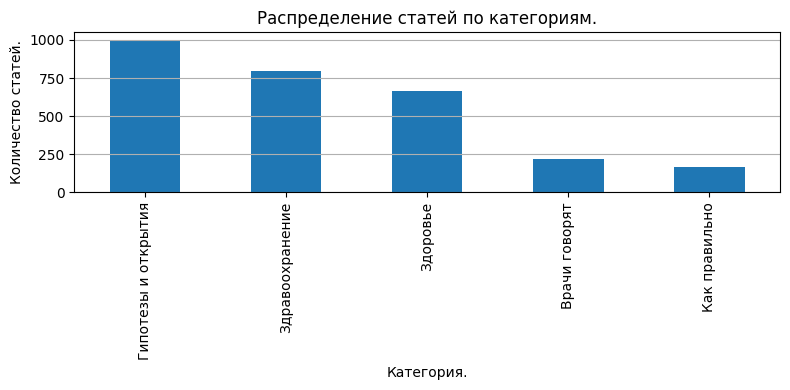

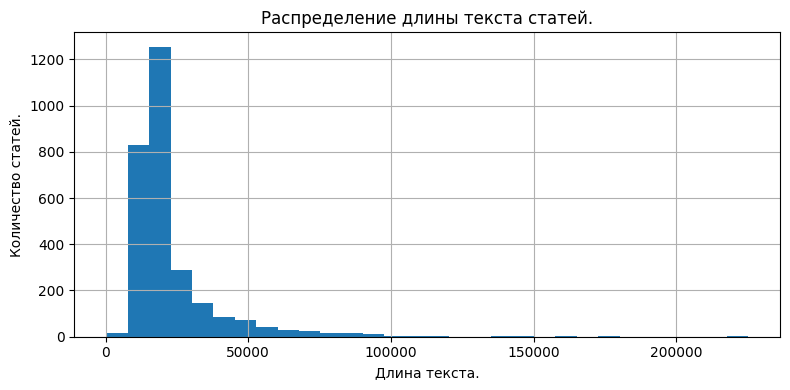

In [ ]:
# Загрузка датасета.
df = pd.read_csv("medportal_dataset_collected.csv")

# Вывод формы датасета.
print("Форма датасета:", df.shape)

# Вывод первых строк датасета.
print("\nПервые строки датасета:")
print(df.head())

# Проверка на наличие пропусков в каждом столбце.
print("\nПропусков по столбцам:")
print(df.isnull().sum())

# Проверка количества уникальных категорий.
print("\nУникальные категории:")
print(df["category"].unique())

# Проверка распределения количества статей по категориям.
print("\nРаспределение категорий:")
print(df["category"].value_counts())

# Проверка наличия дубликатов по URL.
duplicates_url = df.duplicated(subset=["url"]).sum()
print("\nКоличество дубликатов по URL:", duplicates_url)

# Проверка дубликатов по заголовкам.
duplicates_title = df.duplicated(subset=["title"]).sum()
print("Количество дубликатов по заголовкам:", duplicates_title)

# Проверка дубликатов по тексту.
duplicates_text = df.duplicated(subset=["text"]).sum()
print("Количество дубликатов по тексту:", duplicates_text)

# Вывод статистики длины текста.
print("\nСтатистика длины текста:")
print(df["text_length"].describe())

# ВИЗУАЛИЗАЦИЯ ДАННЫХ

# Гистограмма распределения категорий
plt.figure(figsize=(8, 4))
df["category"].value_counts().plot(kind="bar")
plt.title("Распределение статей по категориям.")
plt.xlabel("Категория.")
plt.ylabel("Количество статей.")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Гистограмма длины текстов
plt.figure(figsize=(8, 4))
plt.hist(df["text_length"], bins=30)
plt.title("Распределение длины текста статей.")
plt.xlabel("Длина текста.")
plt.ylabel("Количество статей.")
plt.grid(True)
plt.tight_layout()
plt.show()


# **3.1 ВКР Доработка**

Форма датасета: (2677, 7)

Первые строки датасета:
                                               title  \
0                Потничка у детей: признаки, лечение   
1  Как правильно промывать нос ребенку: основные ...   
2  Барсучий жир: лечение детей с заболеваниями ды...   
3  Какие выбрать детские развивающие игры онлайн ...   
4     Игрушки для детей для развития мелкой моторики   

                                                text date  \
0  Потница — это дерматологическая проблема, возн...  NaN   
1  Насморк у ребёнка – это проблема, знакомая бол...  NaN   
2  Барсучий жир — популярное средство альтернатив...  NaN   
3  В 6-7 лет ребёнок готовится поступать в школу ...  NaN   
4  Великий педагог А. Сухомлинский говорил, что «...  NaN   

                                                 url      source category  \
0  https://medaboutme.ru/articles/potnichka_u_det...  MedAboutMe     Дети   
1  https://medaboutme.ru/articles/kak_pravilno_pr...  MedAboutMe     Дети   
2  https://med

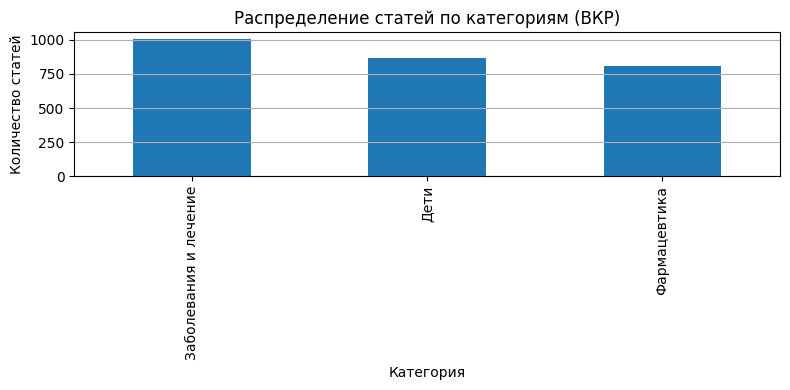

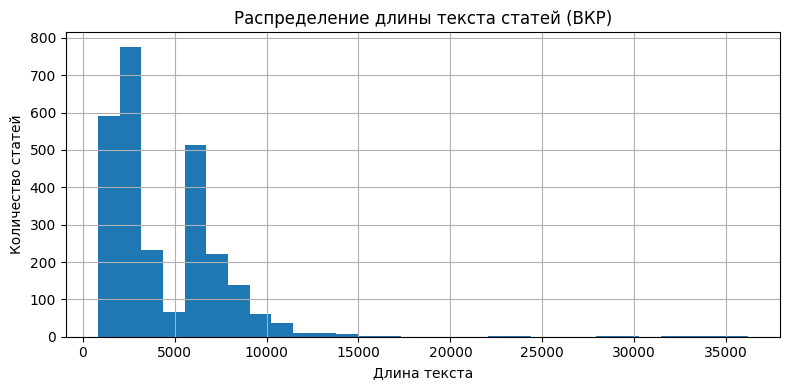

In [3]:
# Анализ новых данных, категории "Дети", "Заболевания и лечение" и "Фармацевтика".

# Загрузка нового датасета.
df_deti = pd.read_csv("medaboutme_deti_collected.csv")
df_diagnostika = pd.read_csv("medaboutme_diagnostika_collected.csv")
df_lekarstva = pd.read_csv("medaboutme_lekarstva_collected.csv")

# Приведение категорий к финальным классам ВКР
df_deti["category"] = "Дети"
df_diagnostika["category"] = "Заболевания и лечение"
df_lekarstva["category"] = "Фармацевтика"

# Объединение данных
df = pd.concat(
    [df_deti, df_diagnostika, df_lekarstva],
    ignore_index=True
)

# Вывод формы датасета.
print("Форма датасета:", df.shape)

# Вывод первых строк датасета.
print("\nПервые строки датасета:")
print(df.head())

# Проверка на наличие пропусков в каждом столбце.
print("\nПропусков по столбцам:")
print(df.isnull().sum())

# Проверка количества уникальных категорий.
print("\nУникальные категории:")
print(df["category"].unique())

# Проверка распределения количества статей по категориям.
print("\nРаспределение категорий:")
print(df["category"].value_counts())

# Проверка наличия дубликатов по URL.
duplicates_url = df.duplicated(subset=["url"]).sum()
print("\nКоличество дубликатов по URL:", duplicates_url)

# Проверка дубликатов по заголовкам.
duplicates_title = df.duplicated(subset=["title"]).sum()
print("Количество дубликатов по заголовкам:", duplicates_title)

# Проверка дубликатов по тексту.
duplicates_text = df.duplicated(subset=["text"]).sum()
print("Количество дубликатов по тексту:", duplicates_text)

# Вывод статистики длины текста.
print("\nСтатистика длины текста:")
print(df["text_length"].describe())

# ВИЗУАЛИЗАЦИЯ ДАННЫХ

# Гистограмма распределения категорий
plt.figure(figsize=(8, 4))
df["category"].value_counts().plot(kind="bar")
plt.title("Распределение статей по категориям (ВКР)")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Гистограмма длины текстов
plt.figure(figsize=(8, 4))
plt.hist(df["text_length"], bins=30)
plt.title("Распределение длины текста статей (ВКР)")
plt.xlabel("Длина текста")
plt.ylabel("Количество статей")
plt.grid(True)
plt.tight_layout()
plt.show()


# **4. Подготовка данных.**


Строки без текста: 0
Количество слишком коротких статей: 0

Размер исходного датасета до очистки: (2850, 7)

Дубликаты по URL: 0
Дубликаты по заголовку: 7
Дубликаты по тексту: 4

Размер датасета после очистки: (2839, 8)

Проверка пропусков по столбцам:
title           0
text            0
url             0
source          0
category        0
text_length     0
text_clean      0
clean_length    0
dtype: int64

Распределение категорий после подготовки:
category
Гипотезы и открытия    998
Здравоохранение        794
Здоровье               666
Врачи говорят          214
Как правильно          167
Name: count, dtype: int64

Первые строки очищенного датасета:
                                               title  \
0  После пандемии медики столкнутся с «вьетнамски...   
1  Ухо, горло, нос: профессор Лейзерман ответит н...   
2  Грудное вскармливание: врачи ответили на главн...   
3                               Из любви к искусству   
4  Доктор, который сделал почку из сосисок и бомб...   

   

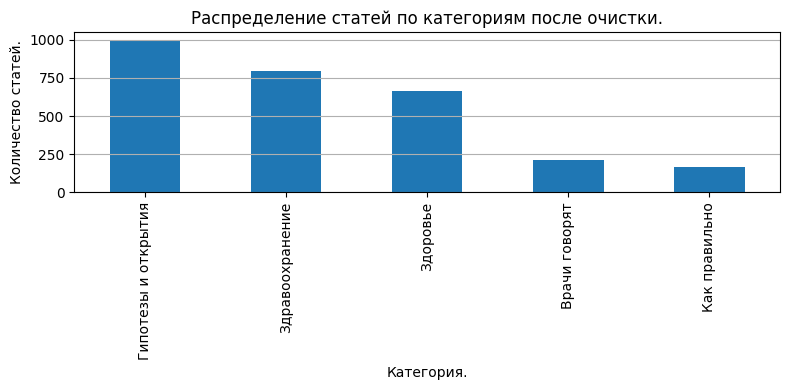

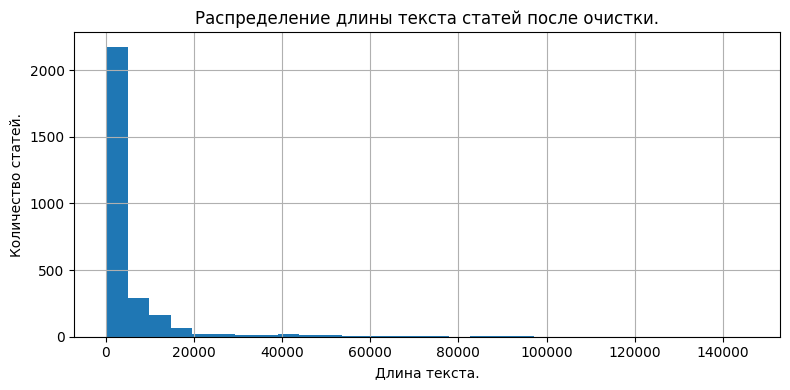

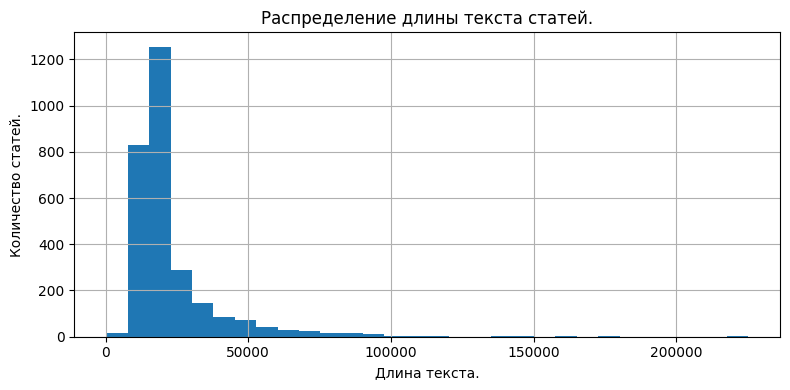

In [ ]:
# ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

# Загрузка датасета, полученного с предыдущего шага.
df = pd.read_csv("medportal_dataset_collected.csv")

# Создание копии датасета, чтобы сохранить оригинал.
data = df.copy()

# Удаление колонки date, так как в ней нет полезной информации.
if "date" in data.columns:
    data = data.drop(columns=["date"])

# Удаление строк, где текст отсутствует.
data = data[data["text"].notna()]

# Подсчет количества пустых текстовых полей.
empty_text = data["text"].isna().sum()
print("\nСтроки без текста:", empty_text)

# Подсчет изначальной длины текстов перед очисткой.
data["text_length"] = data["text"].apply(len)

# Удаление слишком коротких статей менее 300 символов.
short_count = (data["text_length"] < 300).sum()
print("Количество слишком коротких статей:", short_count)
data = data[data["text_length"] >= 300]


# ДОПОЛНИТЕЛЬНАЯ ОЧИСТКА ТЕКСТА
# Создание функции для очистки текста от лишних элементов.
def clean_text_block(text):
    # Удаление административных блоков.
    text = re.sub(r"ООО.? Медпортал.*", " ", text)
    text = re.sub(r"[0-9]{6,}", " ", text)
    text = re.sub(r"info@medportal.ru", " ", text)
    text = re.sub(r"©.*", " ", text)

    # Удаление фразы “Читайте также” и всё после них.
    text = re.split(r"Читайте также", text)[0]

    # Удаление даты и времени в формате "DD MM YYYY, HH:MM"
    text = re.sub(r"\d{1,2} [а-я]+ \d{4}, \d{2}:\d{2}", " ", text)

    # Удаление даты в других форматах.
    text = re.sub(r"\d{1,2} [а-я]+ \d{4}", " ", text)
    text = re.sub(r"\d{2}:\d{2}", " ", text)

    # Удаление названия категорий в начале текста.
    text = re.sub(r"Медновости", " ", text)
    text = re.sub(r"Врачи говорят", " ", text)
    text = re.sub(r"Здоровье", " ", text)
    text = re.sub(r"Как правильно", " ", text)
    text = re.sub(r"Гипотезы и открытия", " ", text)
    text = re.sub(r"Здравоохранение", " ", text)

    # Возврат текста
    return text

# Применение очистки.
data["text_clean"] = data["text"].apply(clean_text_block)

# Ограничение текста 10 абзацами.
def take_first_paragraphs(text, n=10):
    paragraphs = text.split("\n")
    return " ".join(paragraphs[:n])

data["text_clean"] = data["text_clean"].apply(take_first_paragraphs)
data["clean_length"] = data["text_clean"].apply(len)

# ВЫВОД РЕЗУЛЬТАТОВ ОЧИСТКИ

# Вывод размера исходного датасета до очистки.
print("\nРазмер исходного датасета до очистки:", df.shape)

# Удаление дубликатов по URL.
dup_url = data.duplicated(subset=["url"]).sum()
print("\nДубликаты по URL:", dup_url)
data = data.drop_duplicates(subset=["url"])

# Удаление дубликатов по заголовкам.
dup_title = data.duplicated(subset=["title"]).sum()
print("Дубликаты по заголовку:", dup_title)
data = data.drop_duplicates(subset=["title"])

# Удаление дубликатов по тексту.
dup_text = data.duplicated(subset=["text"]).sum()
print("Дубликаты по тексту:", dup_text)
data = data.drop_duplicates(subset=["text"])

# Вывод размера датасета после очистки.
print("\nРазмер датасета после очистки:", data.shape)

# Проверка на наличие пропусков по каждому столбцу.
print("\nПроверка пропусков по столбцам:")
print(data.isnull().sum())

# Вывод распределения категорий после подготовки.
print("\nРаспределение категорий после подготовки:")
print(data["category"].value_counts())

# Вывод первых строк очищенного датасета.
print("\nПервые строки очищенного датасета:")
print(data.head())

# Вывод нескольких примеров текста.
for i in range(1, 4):
    print(f"\nПример текста {i}:")
    print(data.iloc[i]["text_clean"][:500], " ...")

# Сохранение финального очищенного файла.
data.to_csv("medportal_dataset_cleaned.csv", index=False, encoding="utf-8")
print("\nОчищенный датасет сохранён как: medportal_dataset_cleaned.csv")

# ВИЗУАЛИЗАЦИЯ ДАННЫХ ПОСЛЕ ПОДГОТОВКИ И ОЧИСТКИ

# Гистограмма распределения категорий
plt.figure(figsize=(8, 4))
data["category"].value_counts().plot(kind="bar")
plt.title("Распределение статей по категориям после очистки.")
plt.xlabel("Категория.")
plt.ylabel("Количество статей.")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Гистограмма длины текстов
plt.figure(figsize=(8, 4))
plt.hist(data["clean_length"], bins=30)
plt.title("Распределение длины текста статей после очистки.")
plt.xlabel("Длина текста.")
plt.ylabel("Количество статей.")
plt.grid(True)
plt.tight_layout()
plt.show()




# **4.1 ВКР Доработка**

Размер объединённого нового датасета: (2677, 7)
Удалено слишком коротких статей: 0
Дубликаты по URL: 18
Дубликаты по заголовку: 4
Дубликаты по тексту: 0
Размер датасета после очистки: (2655, 8)

Проверка пропусков по столбцам:
title           0
text            0
url             0
source          0
category        0
text_length     0
text_clean      0
clean_length    0
dtype: int64

Распределение категорий после подготовки:
category
Заболевания и лечение    997
Дети                     866
Фармацевтика             792
Name: count, dtype: int64

Первые строки очищенного датасета:
                                               title  \
0                Потничка у детей: признаки, лечение   
1  Как правильно промывать нос ребенку: основные ...   
2  Барсучий жир: лечение детей с заболеваниями ды...   
3  Какие выбрать детские развивающие игры онлайн ...   
4     Игрушки для детей для развития мелкой моторики   

                                                text  \
0  Потница — это дерма

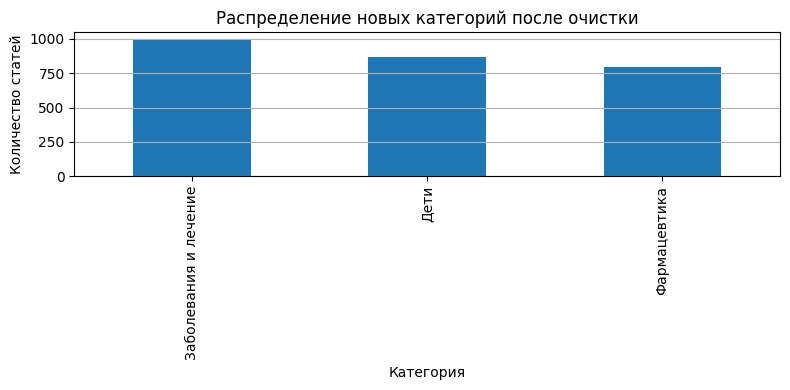

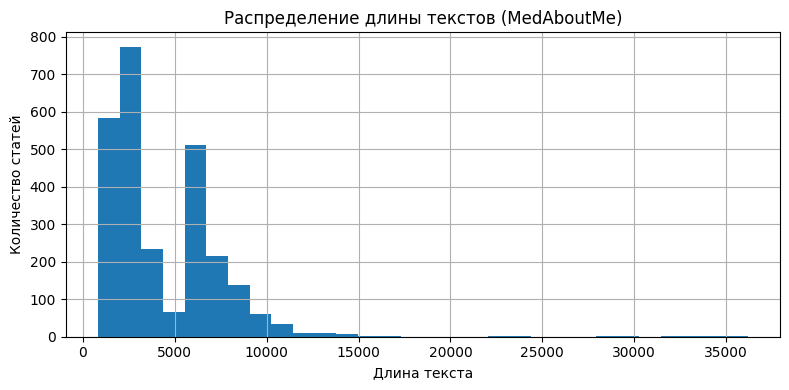

In [5]:
# ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА НОВЫХ ДАННЫХ (MedAboutMe)

# Загрузка новых датасетов.
df_deti = pd.read_csv("medaboutme_deti_collected.csv")
df_diagnostika = pd.read_csv("medaboutme_diagnostika_collected.csv")
df_lekarstva = pd.read_csv("medaboutme_lekarstva_collected.csv")

# Приведение категорий к финальным классам
df_deti["category"] = "Дети"
df_diagnostika["category"] = "Заболевания и лечение"
df_lekarstva["category"] = "Фармацевтика"

# Объединение новых датасетов
data_new = pd.concat(
    [df_deti, df_diagnostika, df_lekarstva],
    ignore_index=True
)

print("Размер объединённого нового датасета:", data_new.shape)


# Удаление колонки date, так как в ней нет полезной информации.
if "date" in data_new.columns:
    data_new = data_new.drop(columns=["date"])

# Удаление строк, где текст отсутствует.
data_new = data_new[data_new["text"].notna()]

# Подсчет изначальной длины текстов перед очисткой.
data_new["text_length"] = data_new["text"].apply(len)

# Удаление слишком коротких статей менее 300 символов.
short_count = (data_new["text_length"] < 300).sum()
print("Удалено слишком коротких статей:", short_count)
data_new = data_new[data_new["text_length"] >= 300]

# ДОПОЛНИТЕЛЬНАЯ ОЧИСТКА ТЕКСТА
# Создание функции для очистки текста от лишних элементов.
def clean_text_medaboutme(text):
    # Удаление фразы "Читайте также" и всего после неё.
    text = re.split(r"Читайте также", text)[0]

    # Удаление длинных числовых последовательностей.
    text = re.sub(r"\d{6,}", " ", text)

    # Удаление HTML-остатков и лишних пробелов.
    text = re.sub(r"\s+", " ", text)

    # Возврат текста.
    return text.strip()

# Применение очистки.
data_new["text_clean"] = data_new["text"].apply(clean_text_medaboutme)

# Ограничение текста 10 абзацами.
def take_first_paragraphs(text, n=10):
    paragraphs = text.split("\n")
    return " ".join(paragraphs[:n])

data_new["text_clean"] = data_new["text_clean"].apply(take_first_paragraphs)
data_new["clean_length"] = data_new["text_clean"].apply(len)

# Удаление дубликатов по URL.
dup_url = data_new.duplicated(subset=["url"]).sum()
print("Дубликаты по URL:", dup_url)
data_new = data_new.drop_duplicates(subset=["url"])

# Удаление дубликатов по заголовкам.
dup_title = data_new.duplicated(subset=["title"]).sum()
print("Дубликаты по заголовку:", dup_title)
data_new = data_new.drop_duplicates(subset=["title"])

# Удаление дубликатов по тексту.
dup_text = data_new.duplicated(subset=["text_clean"]).sum()
print("Дубликаты по тексту:", dup_text)
data_new = data_new.drop_duplicates(subset=["text_clean"])

# Вывод размера датасета после очистки.
print("Размер датасета после очистки:", data_new.shape)

# Проверка на наличие пропусков по каждому столбцу.
print("\nПроверка пропусков по столбцам:")
print(data_new.isnull().sum())

# Вывод распределения категорий после подготовки.
print("\nРаспределение категорий после подготовки:")
print(data_new["category"].value_counts())

# Вывод первых строк очищенного датасета.
print("\nПервые строки очищенного датасета:")
print(data_new.head())

# Вывод нескольких примеров текста.
for i in range(1, 4):
    print(f"\nПример текста {i}:")
    print(data_new.iloc[i]["text_clean"][:500], " ...")

# Сохранение финального очищенного файла.
output_file = "medaboutme_dataset_cleaned.csv"
data_new.to_csv(output_file, index=False, encoding="utf-8")
print("\nОчищенный датасет сохранён как:", output_file)


# ВИЗУАЛИЗАЦИЯ ДАННЫХ ПОСЛЕ ПОДГОТОВКИ И ОЧИСТКИ

# Гистограмма распределения категорий
plt.figure(figsize=(8, 4))
data_new["category"].value_counts().plot(kind="bar")
plt.title("Распределение новых категорий после очистки")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Гистограмма длины текстов
plt.figure(figsize=(8, 4))
plt.hist(data_new["clean_length"], bins=30)
plt.title("Распределение длины текстов (MedAboutMe)")
plt.xlabel("Длина текста")
plt.ylabel("Количество статей")
plt.grid(True)
plt.tight_layout()
plt.show()


# **5. Группировка категорий.**

Размер датасета перед группировкой: (2839, 8)

Уникальные категории до группировки:
category
Гипотезы и открытия    998
Здравоохранение        794
Здоровье               666
Врачи говорят          214
Как правильно          167
Name: count, dtype: int64

Распределение категорий ПОСЛЕ группировки:
category_new
Здравоохранение и экспертные мнения    1008
Гипотезы и открытия                     998
Общественное здоровье                   833
Name: count, dtype: int64


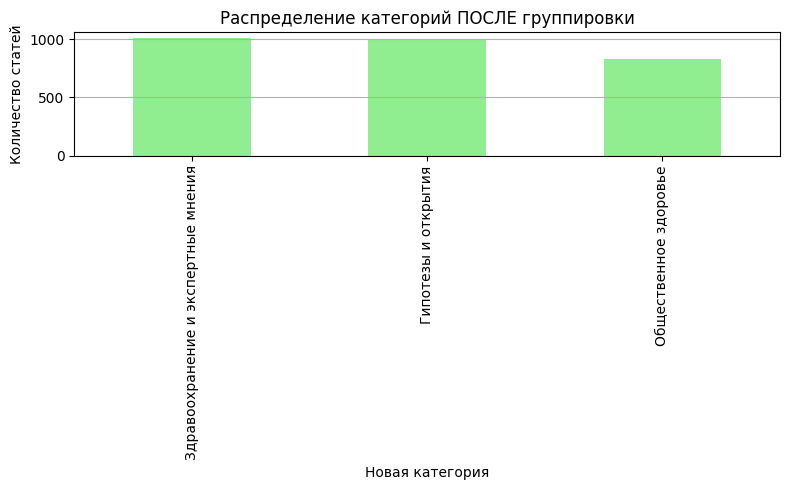


Размер датасета после группировки: (2839, 8)

Итоговый файл с тремя категориями сохранён как: medportal_dataset_grouped.csv


In [ ]:
# ГРУППИРОВКА КАТЕГОРИЙ

# Загрузка очищенного датасета.
df = pd.read_csv("medportal_dataset_cleaned.csv")

# Проверка размера датасета перед группировкой.
print("Размер датасета перед группировкой:", df.shape)

# Вывод уникальных категорий перед группировкой.
print("\nУникальные категории до группировки:")
print(df["category"].value_counts())

# Создание словаря для преобразования категорий.
category_mapping = {
    "Гипотезы и открытия": "Гипотезы и открытия",
    "Здравоохранение": "Здравоохранение и экспертные мнения",
    "Врачи говорят": "Здравоохранение и экспертные мнения",
    "Здоровье": "Общественное здоровье",
    "Как правильно": "Общественное здоровье"
}

# Применение преобразования категорий.
df["category_new"] = df["category"].map(category_mapping)

# Вывод обновлённого распределения категорий.
print("\nРаспределение категорий ПОСЛЕ группировки:")
print(df["category_new"].value_counts())

# Визуализация категорий после группировки.
plt.figure(figsize=(8, 5))
df["category_new"].value_counts().plot(kind="bar", color="lightgreen")
plt.title("Распределение категорий ПОСЛЕ группировки")
plt.xlabel("Новая категория")
plt.ylabel("Количество статей")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Удаление старой колонки с категориями.
df = df.drop(columns=["category"])

# Переименование новой колонки, чтобы она стала основной.
df = df.rename(columns={"category_new": "category"})

# Вывод размера датасета после группировки.
print("\nРазмер датасета после группировки:", df.shape)

# Сохранение датасета после группировки.
output_file = "medportal_dataset_grouped.csv"
df.to_csv(output_file, index=False, encoding="utf-8")

# Вывод названия файла с результатом.
print("\nИтоговый файл с тремя категориями сохранён как:", output_file)


# **5.1 ВКР Доработка**

MedPortal: (2839, 7)
MedAboutMe: (2655, 8)

Колонки MedPortal:
Index(['title', 'text', 'date', 'url', 'source', 'text_length', 'category'], dtype='object')

Колонки MedAboutMe:
Index(['title', 'text', 'url', 'source', 'category', 'text_length',
       'text_clean', 'clean_length'],
      dtype='object')

Проверка наличия обязательных колонок:
True
True

Размер объединённого датасета: (5494, 8)

Дубликаты по URL: 0
Дубликаты по заголовку: 0

Размер после удаления дубликатов: (5494, 8)

Распределение категорий (6 классов):
category
Здравоохранение и экспертные мнения    1008
Гипотезы и открытия                     998
Заболевания и лечение                   997
Дети                                    866
Общественное здоровье                   833
Фармацевтика                            792
Name: count, dtype: int64


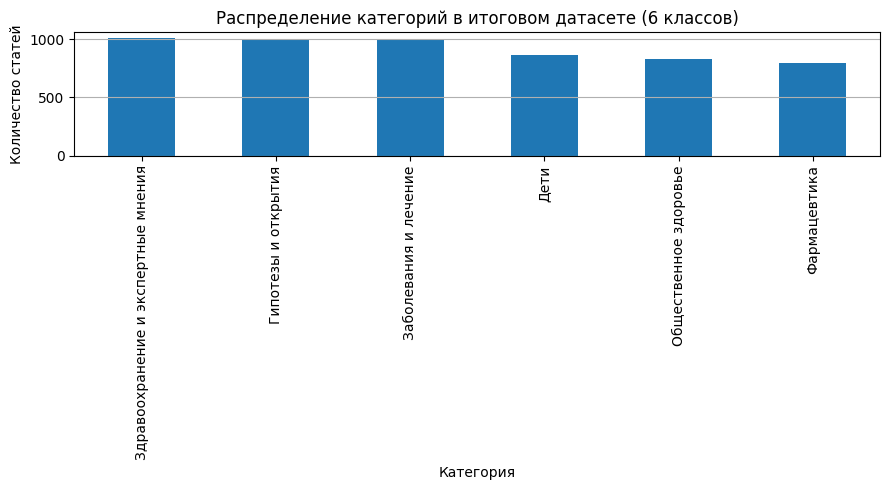


Финальный датасет сохранён как: medical_news_dataset_final.csv


In [ ]:
# Объединение новых датасетов с medportal_dataset_grouped.csv

# Загрузка датасетов.
df_medportal = pd.read_csv("medportal_dataset_grouped.csv")
df_medaboutme = pd.read_csv("medaboutme_dataset_cleaned.csv")

# Проверка размеров датасетов перед группировкой.
print("MedPortal:", df_medportal.shape)
print("MedAboutMe:", df_medaboutme.shape)

# Проверка структуры датасетов.
print("\nКолонки MedPortal:")
print(df_medportal.columns)

print("\nКолонки MedAboutMe:")
print(df_medaboutme.columns)

# Удаление колонки date, если есть.
for df in [df_medportal, df_medaboutme]:
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)

# Проверка обязательных колонок.
required_columns = ["title", "text", "url", "source", "category", "text_clean", "clean_length"]

# Добавление text_clean для MedPortal (используем очищенный text)
df_medportal["text_clean"] = df_medportal["text"]
df_medportal["clean_length"] = df_medportal["text"].apply(len)

# Вывод результатов проверки.
print("\nПроверка наличия обязательных колонок:")
print(set(required_columns).issubset(df_medportal.columns))
print(set(required_columns).issubset(df_medaboutme.columns))

# Объединение датасетов.
df_full = pd.concat([df_medportal, df_medaboutme], ignore_index=True)
# Вывод результата объединения.
print("\nРазмер объединённого датасета:", df_full.shape)

# Подсчет дубликатов по URL и заголовкам.
dup_url = df_full.duplicated(subset=["url"]).sum()
dup_title = df_full.duplicated(subset=["title"]).sum()
print("\nДубликаты по URL:", dup_url)
print("Дубликаты по заголовку:", dup_title)

# Удаление дубликатов по URL и заголовку.
df_full = df_full.drop_duplicates(subset=["url"])
df_full = df_full.drop_duplicates(subset=["title"])
print("\nРазмер после удаления дубликатов:", df_full.shape)

# Вывод распределения данных в категориях.
print("\nРаспределение категорий (6 классов):")
print(df_full["category"].value_counts())

# Гистограмма распределения данных в категориях.
plt.figure(figsize=(9, 5))
df_full["category"].value_counts().plot(kind="bar")
plt.title("Распределение категорий в итоговом датасете (6 классов)")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Сохранение итогового датасета
output_file = "medical_news_dataset_final.csv"
df_full.to_csv(output_file, index=False, encoding="utf-8")
print("\nФинальный датасет сохранён как:", output_file)


# **6. Деление на выборки.**

Размер датасета перед делением: (2839, 8)

Размер обучающей выборки: (1987, 8)
Размер тестовой выборки: (852, 8)

Распределение категорий в обучающей выборке:
category
Здравоохранение и экспертные мнения    705
Гипотезы и открытия                    699
Общественное здоровье                  583
Name: count, dtype: int64

Распределение категорий в тестовой выборке:
category
Здравоохранение и экспертные мнения    303
Гипотезы и открытия                    299
Общественное здоровье                  250
Name: count, dtype: int64


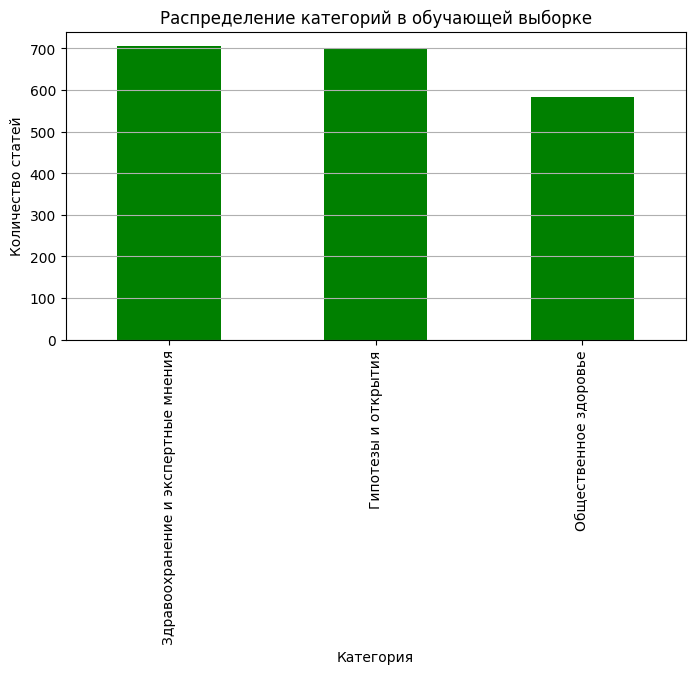

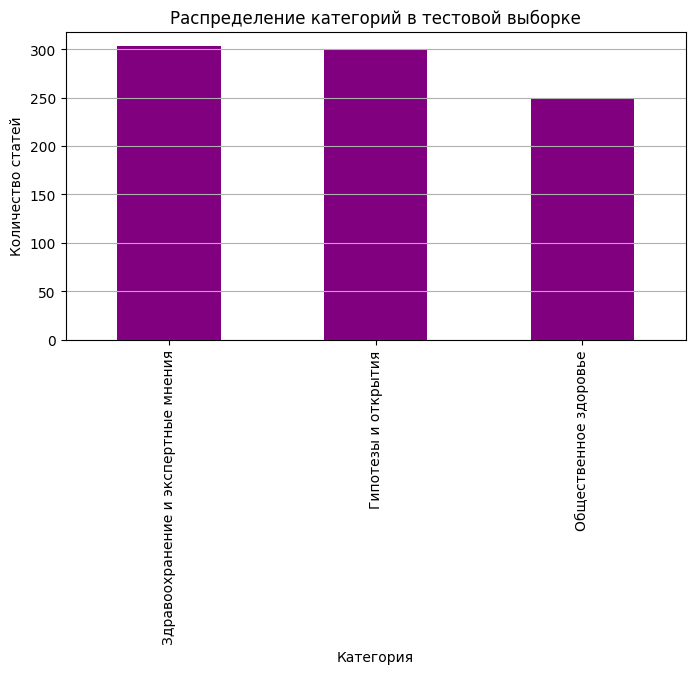


Файлы выборок сохранены как dataset_train.csv и dataset_test.csv


In [ ]:
# ДЕЛЕНИЕ ДАТАСЕТА НА ВЫБОРКИ

# Загрузка подготовленного датасета с тремя категориями.
df = pd.read_csv("medportal_dataset_grouped.csv")

# Вывод размера датасета перед делением.
print("Размер датасета перед делением:", df.shape)

# Деление данных на обучающую (70%) и тестовую (30%) выборки.
# stratify, чтобы сохранить баланс категорий.
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["category"]
)

# Вывод размера получившихся выборок.
print("\nРазмер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

# Вывод распределения категорий в обучающей выборке.
print("\nРаспределение категорий в обучающей выборке:")
print(train_df["category"].value_counts())

# Вывод распределения категорий в тестовой выборке.
print("\nРаспределение категорий в тестовой выборке:")
print(test_df["category"].value_counts())

# ВИЗУАЛИЗАЦИЯ ДАННЫХ ПОСЛЕ ДЕЛЕНИЯ НА ВЫБОРКИ

# Гистограмма распределения категорий в обучающей выборке
plt.figure(figsize=(8,4))
train_df["category"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение категорий в обучающей выборке")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(axis='y')
plt.show()

# Гистограмма распределения категорий в тестовой выборке
plt.figure(figsize=(8,4))
test_df["category"].value_counts().plot(kind="bar", color="purple")
plt.title("Распределение категорий в тестовой выборке")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(axis='y')
plt.show()

# Сохранение обоих выборок в CSV.
train_df.to_csv("dataset_train.csv", index=False, encoding="utf-8")
test_df.to_csv("dataset_test.csv", index=False, encoding="utf-8")

# Вывод сообщения о сохранении данных.
print("\nФайлы выборок сохранены как dataset_train.csv и dataset_test.csv")


# **6.1 ВКР Доработка**

Размер датасета перед делением: (5494, 8)

Размер обучающей выборки: (3845, 8)
Размер тестовой выборки: (1649, 8)

Распределение категорий в обучающей выборке:
category
Здравоохранение и экспертные мнения    705
Гипотезы и открытия                    699
Заболевания и лечение                  698
Дети                                   606
Общественное здоровье                  583
Фармацевтика                           554
Name: count, dtype: int64

Распределение категорий в тестовой выборке:
category
Здравоохранение и экспертные мнения    303
Гипотезы и открытия                    299
Заболевания и лечение                  299
Дети                                   260
Общественное здоровье                  250
Фармацевтика                           238
Name: count, dtype: int64


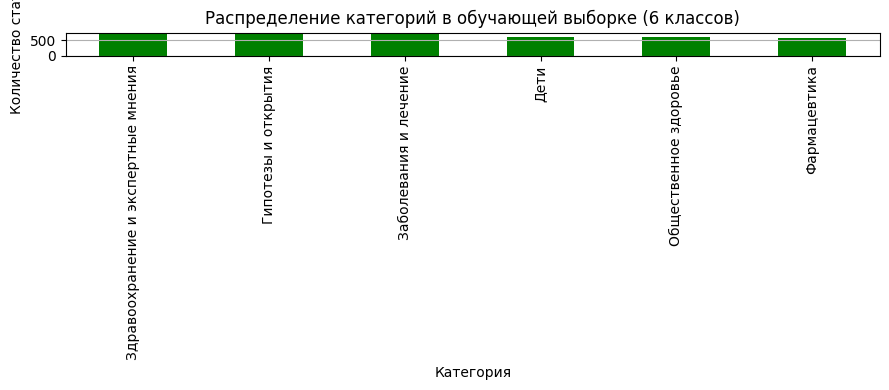

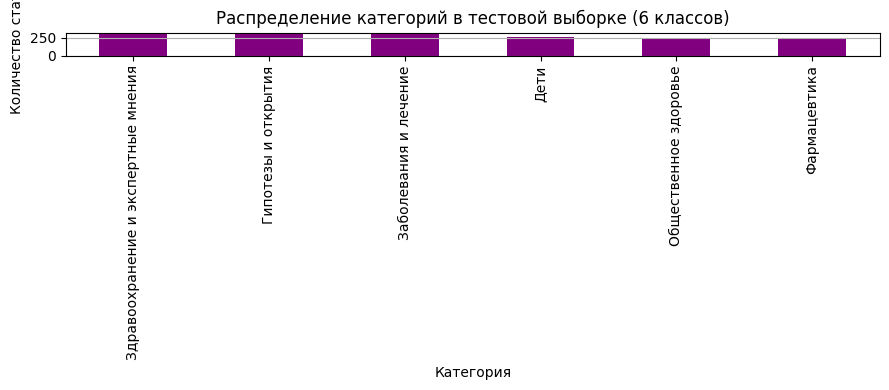


Файлы выборок сохранены как:
dataset_train_6classes.csv
dataset_test_6classes.csv


In [ ]:
# ДЕЛЕНИЕ ФИНАЛЬНОГО ДАТАСЕТА НА ВЫБОРКИ (ВКР)
# Загрузка финального датасета.
df = pd.read_csv("medical_news_dataset_final.csv")

# Проверка размера датасета перед делением.
print("Размер датасета перед делением:", df.shape)

# Деление на обучающую (70%) и тестовую (30%) выборки
# stratify — для сохранения баланса классов
train_df, test_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["category"]
)

# Проверка размеров выборок
print("\nРазмер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

# Распределение категорий в обучающей выборке
print("\nРаспределение категорий в обучающей выборке:")
print(train_df["category"].value_counts())

# Распределение категорий в тестовой выборке
print("\nРаспределение категорий в тестовой выборке:")
print(test_df["category"].value_counts())


# ВИЗУАЛИЗАЦИЯ ДАННЫХ ПОСЛЕ ДЕЛЕНИЯ НА ВЫБОРКИ
# Гистограмма распределения категорий в обучающей выборке
plt.figure(figsize=(9, 4))
train_df["category"].value_counts().plot(kind="bar", color="green")
plt.title("Распределение категорий в обучающей выборке (6 классов)")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Гистограмма распределения категорий в тестовой выборке
plt.figure(figsize=(9, 4))
test_df["category"].value_counts().plot(kind="bar", color="purple")
plt.title("Распределение категорий в тестовой выборке (6 классов)")
plt.xlabel("Категория")
plt.ylabel("Количество статей")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Сохранение обоих выборок в CSV.
train_df.to_csv("dataset_train_6classes.csv", index=False, encoding="utf-8")
test_df.to_csv("dataset_test_6classes.csv", index=False, encoding="utf-8")

# Вывод сообщения о сохранении данных.
print("\nФайлы выборок сохранены как:")
print("dataset_train_6classes.csv")
print("dataset_test_6classes.csv")


# **7. Создание модели.**

In [ ]:
# Базовая реализация модели, разработанная в рамках преддипломной практики
# Загрузка обучающей и тестовой выборок.
train_df = pd.read_csv("dataset_train.csv")
test_df = pd.read_csv("dataset_test.csv")

# Проверка размеров обоих выборок.
print("Размер обучающей выборки:", train_df.shape)
print("Размер тестовой выборки:", test_df.shape)

# ПРЕОБРАЗОВАНИЕ КАТЕГОРИЙ В ЧИСЛОВЫЕ МЕТКИ
# Вывод списока уникальных категорий.
unique_categories = sorted(train_df["category"].unique())
print("\nСписок категорий:", unique_categories)

# Создание кодировщика.
label_encoder = LabelEncoder()

# Обучение кодировщика на названиях категорий.
label_encoder.fit(train_df["category"])

# Преобразование категорий в цифры.
train_df["label"] = label_encoder.transform(train_df["category"])
test_df["label"] = label_encoder.transform(test_df["category"])

# Проверка преобразований.
print("\nРаспределение меток в обучающей выборке:")
print(train_df["label"].value_counts())

# ЗАГРУЗКА РУССКОЙ МОДЕЛИ RuBERT
# Загрузка токенизатора, который будет превращать текст в числовые токены.
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")

# Загрузка модели RuBERT.
model = AutoModelForSequenceClassification.from_pretrained(
    "sberbank-ai/ruBert-base",
    # Настройка классов.
    num_labels=len(unique_categories)
)

# Настройка устройства: GPU если доступен, если нет, то CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перенос модели на выбранное устройство.
model.to(device)

print("\nМодель RuBERT успешно создана.")
print("Модель работает на устройстве:", device)

# СОЗДАНИЕ КЛАССА ДЛЯ ДАТАСЕТА
# Создание нового класса датасета, который будет отдавать по одному тексту за раз.
class NewsDataset(Dataset):

    # Создание конструктора для хранения текстов и меток.
    def __init__(self, texts, labels, tokenizer, max_len=256):
        # Сохрание списка текстов.
        self.texts = texts
        # Сохранение списока цифровых меток.
        self.labels = labels
        # Сохранение токенизатора.
        self.tokenizer = tokenizer
        # Сохранение максимальной длины текста.
        self.max_len = max_len

    # Возврат количества элементов в датасете.
    def __len__(self):
        return len(self.texts)

    # Возврат одного элемента по индексу.
    def __getitem__(self, idx):
        # Текст по индексу.
        text = str(self.texts[idx])
        # Метка по индексу.
        label = int(self.labels[idx])

        # Применение токенизации к тексту.
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Возврат словаря, который понимает модель BERT.
        return {
            # Индексы токенов.
            "input_ids": encoding["input_ids"].squeeze(),
            # Маска внимания.
            "attention_mask": encoding["attention_mask"].squeeze(),
            # Метка класса.
            "labels": torch.tensor(label, dtype=torch.long)
        }

# СОЗДАНИЕ УЧЕБНОГО И ТЕСТОВОГО ДАТАСЕТА
# Создание обучающего датасета.
train_dataset = NewsDataset(
    texts=train_df["text"].tolist(),
    labels=train_df["label"].tolist(),
    tokenizer=tokenizer
)

# Создание тестового датасета.
test_dataset = NewsDataset(
    texts=test_df["text"].tolist(),
    labels=test_df["label"].tolist(),
    tokenizer=tokenizer
)

# СОЗДАНИЕ DATALOADER ДЛЯ ПАКЕТНОЙ ПОДАЧИ ДАННЫХ
# Создание DataLoader для обучения.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Создание DataLoader для тестирования.
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Вывод результата.
print("Количество батчей в train_loader:", len(train_loader))
print("Количество батчей в test_loader:", len(test_loader))


Размер обучающей выборки: (1987, 8)
Размер тестовой выборки: (852, 8)

Список категорий: ['Гипотезы и открытия', 'Здравоохранение и экспертные мнения', 'Общественное здоровье']

Распределение меток в обучающей выборке:
label
1    705
0    699
2    583
Name: count, dtype: int64


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Модель RuBERT успешно создана.
Модель работает на устройстве: cuda
Количество батчей в train_loader: 497
Количество батчей в test_loader: 213


# **8. Обучение модели.**

Начало обучение модели...

Эпоха 1/5 — Потери: 0.0112, Точность: 0.9985
Эпоха 2/5 — Потери: 0.0137, Точность: 0.9980
Эпоха 3/5 — Потери: 0.0058, Точность: 0.9985
Эпоха 4/5 — Потери: 0.0004, Точность: 1.0000
Эпоха 5/5 — Потери: 0.0003, Точность: 1.0000

Обучение завершено за 760.74 секунд.

Точность на тестовой выборке: 0.9977

Классификационный отчёт:
                                     precision    recall  f1-score   support

                Гипотезы и открытия       1.00      1.00      1.00       299
Здравоохранение и экспертные мнения       1.00      0.99      1.00       303
              Общественное здоровье       1.00      1.00      1.00       250

                           accuracy                           1.00       852
                          macro avg       1.00      1.00      1.00       852
                       weighted avg       1.00      1.00      1.00       852



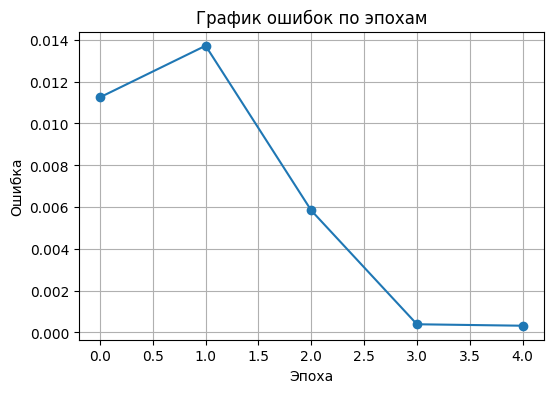

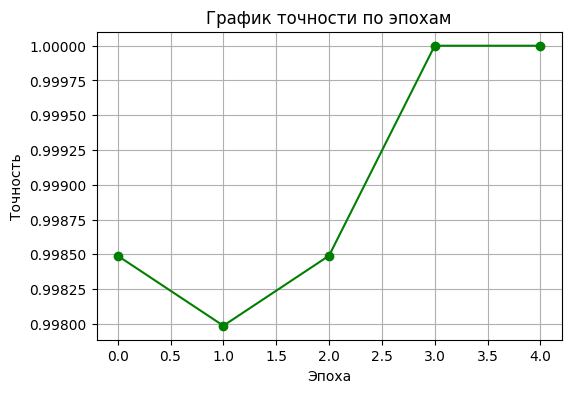

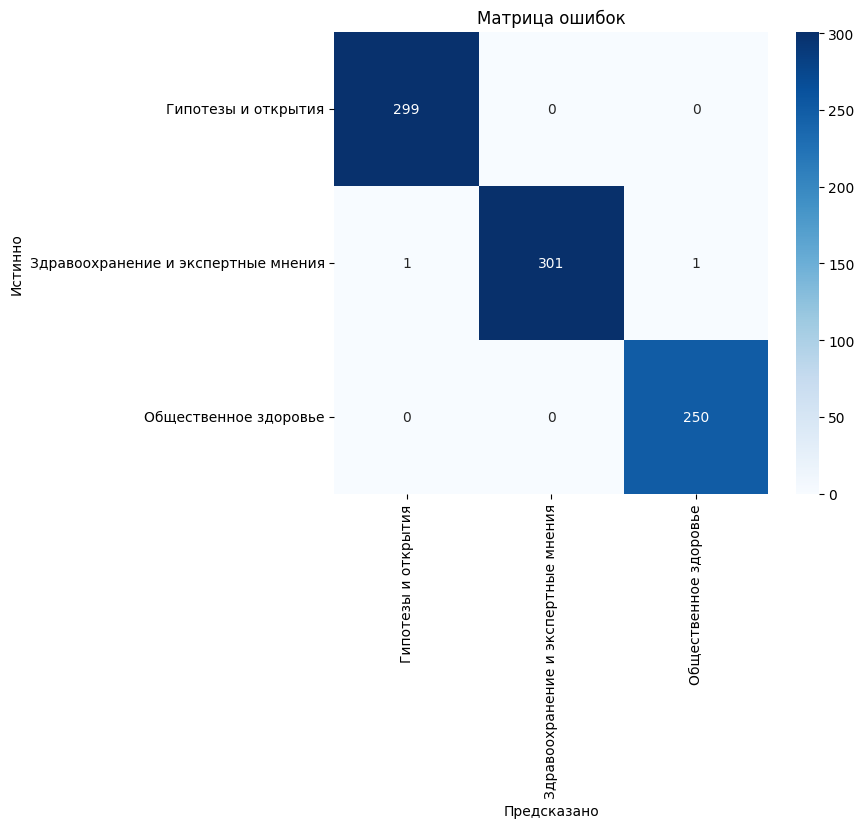

Общая точность (Accuracy) модели: 1.0

Модель и токенизатор сохранены в папку finetuned_rubert_medportal.


In [ ]:
# Базовая реализация модели, разработанная в рамках преддипломной практики
# ОБУЧЕНИЕ МОДЕЛИ
# Создание оптимизатор AdamW.
optimizer = AdamW(model.parameters(), lr=2e-5)

# Настройка количества эпох обучения.
num_epochs = 5

# Количество шагов обучения для планировщика.
total_steps = len(train_loader) * num_epochs

# Создание планировщика, который постепенно уменьшает скорость обучения.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Создание функции для одной эпохи обучения модели.
def train_one_epoch(model, data_loader, optimizer, scheduler, device):
    # Перевод модели в режим обучения.
    model.train()

    # Создание списка для хранения истинных и предсказанных меток.
    all_preds = []
    all_labels = []

    # Создание переменной для накопления ошибок.
    total_loss = 0

    # Для каждого батча из DataLoader.
    for batch in data_loader:
        # Перенос входных данных на устройство.
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Обнуление градиентов.
        optimizer.zero_grad()

        # Прямой проход модели.
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Возврат ошибки.
        loss = outputs.loss
        # Добавление ошибки в общую сумму.
        total_loss += loss.item()
        # Обратное распространение.
        loss.backward()
        # Обновление весов модели.
        optimizer.step()
        # Обновление скорости обучения.
        scheduler.step()
        # Возврат предсказанных классов.
        preds = torch.argmax(outputs.logits, dim=1)
        # Добавление предсказаний и настоящих меток в списки.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Вычисление средней ошибки и точности.
    avg_loss = total_loss / len(data_loader)
    avg_acc = accuracy_score(all_labels, all_preds)

    # Возврат результатов.
    return avg_loss, avg_acc

# Создание функции для оценки модели на тестовой выборке.
def evaluate_model(model, data_loader, device):
    # Перевод модели в режим оценки.
    model.eval()
    # Создание списков для сбора предсказаний и истинных меток.
    all_preds = []
    all_labels = []
    # Запрет подсчёта градиентов.
    with torch.no_grad():
        for batch in data_loader:
            # Перенос входных данных на устройство.
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            # Получение редсказаний модели.
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Преобразование логитов в метки.
            preds = torch.argmax(outputs.logits, dim=1)
            # Сохранение предсказаний.
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Вычисление точности.
    accuracy = accuracy_score(all_labels, all_preds)

    # Возврат точности и массивов для отчёта.
    return accuracy, all_labels, all_preds

# Создание списков для хранения истории обучения.
train_losses = []
train_accs = []

# Запуск обучения модели.
print("Начало обучение модели...\n")
start_time = time.time()

for epoch in range(num_epochs):
    # Обучение одной эпохи.
    loss, acc = train_one_epoch(model, train_loader, optimizer, scheduler, device)

    # Сохранение результатов в историю.
    train_losses.append(loss)
    train_accs.append(acc)

    # Вывод промежуточных результатов.
    print(f"Эпоха {epoch+1}/{num_epochs} — Потери: {loss:.4f}, Точность: {acc:.4f}")

# ПРОВЕРКА ЭФФЕКТИВНОСТИ МОДЕЛИ.
# Вычисление времени обучения.
total_time = time.time() - start_time
print(f"\nОбучение завершено за {total_time:.2f} секунд.\n")

# Тестирование модели.
test_acc, true_labels, pred_labels = evaluate_model(model, test_loader, device)
print(f"Точность на тестовой выборке: {test_acc:.4f}\n")

# Классификационный отчёт.
print("Классификационный отчёт:")
print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

# ВИЗУАЛИЗАЦИЯ ОбУЧЕНИЯ МОДЕЛИ

# Гисторамма ошибок по эпохам.
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker="o")
plt.title("График ошибок по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.grid()
plt.show()

# Гисторамма точности по эпохам
plt.figure(figsize=(6,4))
plt.plot(train_accs, marker="o", color="green")
plt.title("График точности по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.grid()
plt.show()


# Создание матрицы ошибок (Confusion matrix).
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Матрица ошибок")
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.show()


print("Общая точность (Accuracy) модели:", round(acc, 4))

# СОХРАНЕНИЕ МОДЕЛИ.

# Сохранение обученной модели и токенайзера (если нужно сохранить в Colab пространстве).
# model.save_pretrained("finetuned_rubert_medportal")
# tokenizer.save_pretrained("finetuned_rubert_medportal")

# Сохранение обученной модели и токенайзера на Google Drive.
model.save_pretrained("/content/drive/MyDrive/finetuned_rubert_medportal")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_rubert_medportal")


print("\nМодель и токенизатор сохранены в папку finetuned_rubert_medportal.")




# **8.1 ВКР Доработка**

In [ ]:
# В данной части кода используется расширенный датасет,
# сформированный в рамках выпускной квалификационной работы.
# В отличие от практической работы (3 класса), здесь используется 6 тематических классов.

# Загрузка обучающей и тестовой выборок.
train_df = pd.read_csv("dataset_train_6classes.csv")
test_df = pd.read_csv("dataset_test_6classes.csv")

# Проверка размеров обоих выборок.
print("Размер обучающей выборки (ВКР):", train_df.shape)
print("Размер тестовой выборки (ВКР):", test_df.shape)

# ПРЕОБРАЗОВАНИЕ КАТЕГОРИЙ В ЧИСЛОВЫЕ МЕТКИ
# Вывод списока уникальных категорий.
unique_categories = sorted(train_df["category"].unique())
print("\nСписок категорий (6 классов):")
for i, cat in enumerate(unique_categories):
    print(f"{i}: {cat}")

# Создание кодировщика.
label_encoder = LabelEncoder()

# Обучение кодировщика на названиях категорий.
label_encoder.fit(train_df["category"])

# Преобразование категорий в числовые метки.
train_df["label"] = label_encoder.transform(train_df["category"])
test_df["label"] = label_encoder.transform(test_df["category"])

# Проверка распределения меток.
print("\nРаспределение меток в обучающей выборке:")
print(train_df["label"].value_counts())

# ЗАГРУЗКА РУССКОЙ МОДЕЛИ RuBERT
# Загрузка токенизатора, который будет превращать текст в числовые токены.
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")

# Загрузка модели RuBERT.
model = AutoModelForSequenceClassification.from_pretrained(
    "sberbank-ai/ruBert-base",
    num_labels=len(unique_categories)
)

# Настройка устройства: GPU если доступен, если нет, то CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Перенос модели на выбранное устройство.
model.to(device)

print("\nМодель RuBERT для ВКР успешно загружена.")
print("Используемое устройство:", device)

# СОЗДАНИЕ КЛАССА ДЛЯ ДАТАСЕТА
# Создание нового класса датасета, который будет отдавать по одному тексту за раз.
class NewsDataset(Dataset):

    # Создание конструктора для хранения текстов и меток.
    def __init__(self, texts, labels, tokenizer, max_len=256):
        # Сохрание списка текстов.
        self.texts = texts
        # Сохранение списка цифровых меток.
        self.labels = labels
        # Сохранение токенизатора.
        self.tokenizer = tokenizer
        # Сохранение максимальной длины текста.
        self.max_len = max_len

    # Возврат количества элементов в датасете.
    def __len__(self):
        return len(self.texts)

    # Возврат одного элемента по индексу.
    def __getitem__(self, idx):
        # Текст по индексу.
        text = str(self.texts[idx])
        # Метка по индексу.
        label = int(self.labels[idx])

        # Применение токенизации к тексту.
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Возврат словаря, который понимает модель BERT.
        return {
            # Индексы токенов.
            "input_ids": encoding["input_ids"].squeeze(),
            # Маска внимания.
            "attention_mask": encoding["attention_mask"].squeeze(),
            # Метка класса.
            "labels": torch.tensor(label, dtype=torch.long)
        }

# СОЗДАНИЕ УЧЕБНОГО И ТЕСТОВОГО ДАТАСЕТА
# Создание обучающего датасета с использованием очищенного текста (text_clean).
train_dataset = NewsDataset(
    texts=train_df["text_clean"].tolist(),
    labels=train_df["label"].tolist(),
    tokenizer=tokenizer
)

# Создание тестового датасета.
test_dataset = NewsDataset(
    texts=test_df["text_clean"].tolist(),
    labels=test_df["label"].tolist(),
    tokenizer=tokenizer
)

# СОЗДАНИЕ DATALOADER ДЛЯ ПАКЕТНОЙ ПОДАЧИ ДАННЫХ
# Создание DataLoader для обучения.
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Создание DataLoader для тестирования.
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Вывод результата.
print("\nКоличество батчей:")
print("train_loader:", len(train_loader))
print("test_loader:", len(test_loader))


Размер обучающей выборки (ВКР): (3845, 8)
Размер тестовой выборки (ВКР): (1649, 8)

Список категорий (6 классов):
0: Гипотезы и открытия
1: Дети
2: Заболевания и лечение
3: Здравоохранение и экспертные мнения
4: Общественное здоровье
5: Фармацевтика

Распределение меток в обучающей выборке:
label
3    705
0    699
2    698
1    606
4    583
5    554
Name: count, dtype: int64


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Модель RuBERT для ВКР успешно загружена.
Используемое устройство: cuda

Количество батчей:
train_loader: 962
test_loader: 413


Начало обучения модели (ВКР, 6 классов)...

Эпоха 1/5 — Потери: 0.3187, Точность: 0.8957
Эпоха 2/5 — Потери: 0.0819, Точность: 0.9769
Эпоха 3/5 — Потери: 0.0241, Точность: 0.9948
Эпоха 4/5 — Потери: 0.0182, Точность: 0.9966
Эпоха 5/5 — Потери: 0.0063, Точность: 0.9992

Обучение завершено за 1349.80 секунд.

Точность на тестовой выборке: 0.9703

Классификационный отчёт:
                                     precision    recall  f1-score   support

                Гипотезы и открытия       1.00      1.00      1.00       299
                               Дети       0.93      0.93      0.93       260
              Заболевания и лечение       0.94      0.96      0.95       299
Здравоохранение и экспертные мнения       1.00      0.99      1.00       303
              Общественное здоровье       1.00      1.00      1.00       250
                       Фармацевтика       0.96      0.93      0.94       238

                           accuracy                           0.97      1649
          

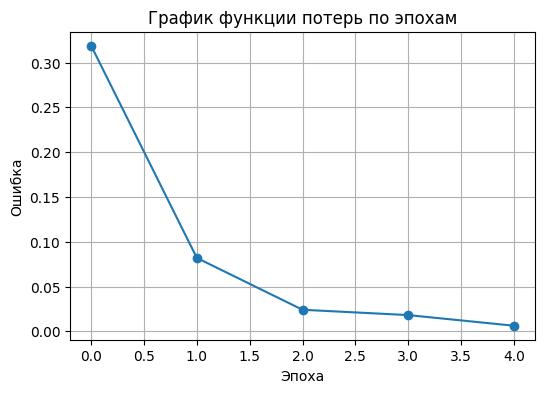

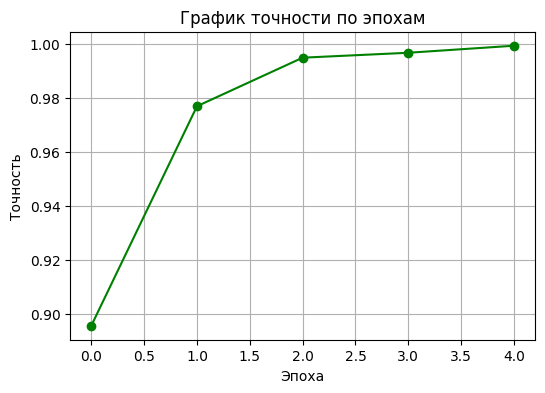

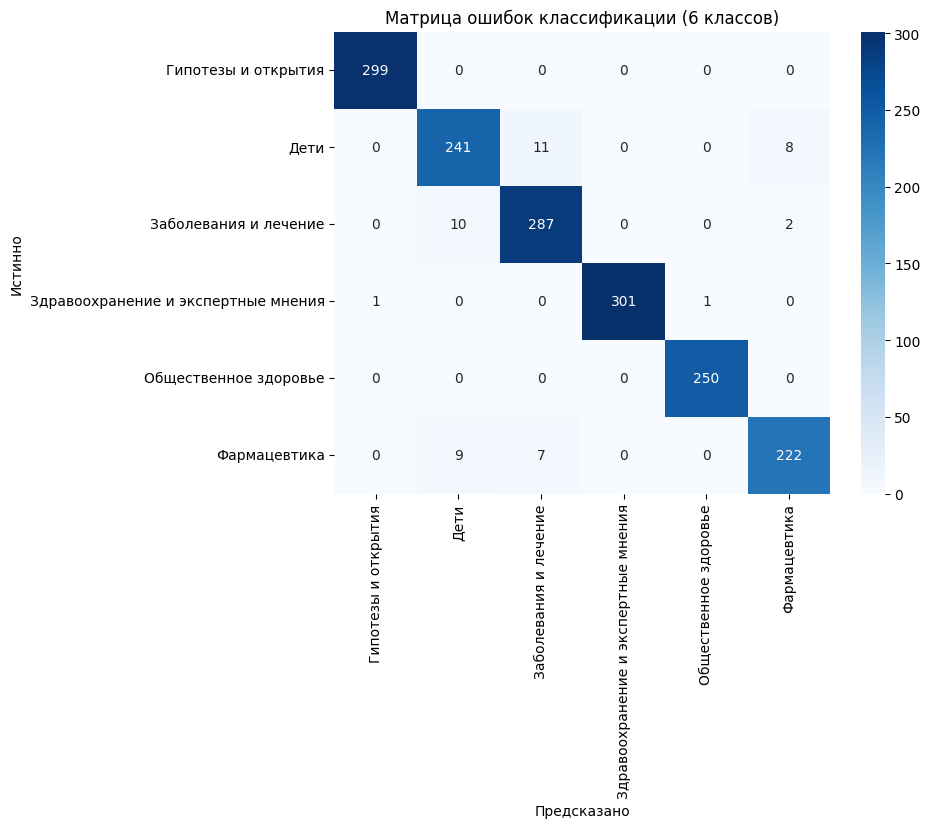

Финальная точность модели (Accuracy): 0.9703

Модель и токенизатор сохранены (ВКР версия).


In [ ]:
# ======================================
# ВКР ДОРАБОТКА: ОБУЧЕНИЕ МОДЕЛИ (6 КЛАССОВ)
# ======================================

# ОБУЧЕНИЕ МОДЕЛИ

# Создание оптимизатора AdamW.
optimizer = AdamW(model.parameters(), lr=2e-5)

# Настройка количества эпох обучения.
num_epochs = 5

# Количество шагов обучения для планировщика.
total_steps = len(train_loader) * num_epochs

# Создание планировщика, который постепенно уменьшает скорость обучения.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Создание функции для одной эпохи обучения модели.
def train_one_epoch(model, data_loader, optimizer, scheduler, device):
    # Перевод модели в режим обучения.
    model.train()

    # Списки для хранения истинных и предсказанных меток.
    all_preds = []
    all_labels = []

    # Переменная для накопления ошибки.
    total_loss = 0

    # Для каждого батча из DataLoader.
    for batch in data_loader:
        # Перенос входных данных на устройство.
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Обнуление градиентов.
        optimizer.zero_grad()

        # Прямой проход модели.
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        # Получение ошибки.
        loss = outputs.loss
        total_loss += loss.item()

        # Обратное распространение ошибки.
        loss.backward()

        # Обновление весов модели.
        optimizer.step()

        # Обновление скорости обучения.
        scheduler.step()

        # Получение предсказанных классов.
        preds = torch.argmax(outputs.logits, dim=1)

        # Сохранение предсказаний и истинных меток.
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Вычисление средней ошибки и точности.
    avg_loss = total_loss / len(data_loader)
    avg_acc = accuracy_score(all_labels, all_preds)

    return avg_loss, avg_acc


# Создание функции для оценки модели на тестовой выборке.
def evaluate_model(model, data_loader, device):
    # Перевод модели в режим оценки.
    model.eval()

    all_preds = []
    all_labels = []

    # Отключение подсчёта градиентов.
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    return accuracy, all_labels, all_preds


# --------------------------------------
# ЗАПУСК ОБУЧЕНИЯ
# --------------------------------------

train_losses = []
train_accs = []

print("Начало обучения модели (ВКР, 6 классов)...\n")
start_time = time.time()

for epoch in range(num_epochs):
    loss, acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        scheduler,
        device
    )

    train_losses.append(loss)
    train_accs.append(acc)

    print(f"Эпоха {epoch+1}/{num_epochs} — Потери: {loss:.4f}, Точность: {acc:.4f}")

total_time = time.time() - start_time
print(f"\nОбучение завершено за {total_time:.2f} секунд.\n")


# --------------------------------------
# ТЕСТИРОВАНИЕ МОДЕЛИ
# --------------------------------------

test_acc, true_labels, pred_labels = evaluate_model(
    model,
    test_loader,
    device
)

print(f"Точность на тестовой выборке: {test_acc:.4f}\n")

print("Классификационный отчёт:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=label_encoder.classes_
))


# --------------------------------------
# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ
# --------------------------------------

# График ошибок по эпохам.
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker="o")
plt.title("График функции потерь по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.grid()
plt.show()

# График точности по эпохам.
plt.figure(figsize=(6,4))
plt.plot(train_accs, marker="o", color="green")
plt.title("График точности по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.grid()
plt.show()


# Матрица ошибок (Confusion Matrix).
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Матрица ошибок классификации (6 классов)")
plt.xlabel("Предсказано")
plt.ylabel("Истинно")
plt.show()


print("Финальная точность модели (Accuracy):", round(test_acc, 4))


# --------------------------------------
# СОХРАНЕНИЕ МОДЕЛИ
# --------------------------------------

model.save_pretrained("/content/drive/MyDrive/finetuned_rubert_medical_vkr")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_rubert_medical_vkr")

print("\nМодель и токенизатор сохранены (ВКР версия).")


# **ТЕСТИРОВАНИЕ МОДЕЛИ**

# **10. Перезапуск модели.**

In [ ]:
# Обязательно перед запуском теста!
!pip install transformers==4.35.2
!pip install accelerate --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 111.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.2
    Uninstalling tokenizers-0.22.2:
      Successfully uninstalled tokenizers-0.22.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.


In [ ]:
# Обязательно перед запуском теста!
model_dir = "/content/drive/MyDrive/finetuned_rubert_medportal"

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)

# Загружаем модель
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir,
    local_files_only=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Модель успешно загружена!")


Модель успешно загружена!


In [ ]:
# Проверка простого предсказания
text = "Ежедневные прогулки улучшают восстановление после инсульта."
enc = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

with torch.no_grad():
    logits = model(**enc).logits
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

print("Probabilities:", probs)
print("Predicted label:", np.argmax(probs))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Probabilities: [0.25456008 0.07236893 0.673071  ]
Predicted label: 2


# **11. Тестирование по принципу работы с приложением**

In [ ]:
# Словарь для преобразования числовых меток обратно в текстовые категории.
inv_map = {
    0: 'Гипотезы и открытия',
    1: 'Здравоохранение и экспертные мнения',
    2: 'Общественное здоровье'
}

# Создание функции предсказания с механизмом отклонения результатов при низкой уверенности
def predict_with_rejection(text, threshold=0.6, max_length=256):
    # Проверка корректности формата.
    if not isinstance(text, str) or not text.strip():
        return {"error": "Некорректный формат текста."}

    # Токенизация текста, преобразование в индексы.
    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    # Перенос всех токенов на выбранное устройство (CPU или GPU).
    enc = {k: v.to(device) for k, v in enc.items()}

    # Отключение вычисления градиентов.
    with torch.no_grad():
        # Прямой проход модели.
        outputs = model(**enc)
        # Извлечение логитов.
        logits = outputs.logits
        # Перевод в вероятности.
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Поиск наиболее вероятного класса.
    # Индекс класса.
    max_idx = int(np.argmax(probs))
    # Уверенность модели.
    max_prob = float(probs[max_idx])

    # Логика отклонения предсказания.
    # Если меньше порога, отклонение классификации.
    if max_prob < threshold:
        decision = "Статья не относится к медицине, или не достаточно уверенности для классификации."
    else:
        decision = "Классифицированно."

    # Возврат результатов предсказания.
    return {
        "label_id": max_idx,
        "label_name": inv_map.get(max_idx),
        "max_prob": max_prob,
        "probs": probs,
        "decision": decision
    }


# Позитивное тестирование
print("\nПОЗИТИВНОЕ ТЕСТИРОВАНИЕ")

positive_tests = [
    # Должно попасть в «Гипотезы и открытия»
    "Исследователи обнаружили новый механизм регенерации тканей печени у млекопитающих.",

    # Должно попасть в «Здравоохранение и экспертные мнения»
    "Минздрав обновил клинические рекомендации по лечению хронической сердечной недостаточности.",

    # Должно попасть в «Общественное здоровье»
    "Врачи рекомендуют ежедневно проходить не менее 8000 шагов для снижения риска ожирения."
]

for i, text in enumerate(positive_tests, 1):
    res = predict_with_rejection(text)
    print(f"\nТест {i}:")
    print(res)


# Негативное тестирование.
print("\nНЕГАТИВНОЕ ТЕСТИРОВАНИЕ")

negative_tests = {
    "Статья не по медицине":
        "Команда выиграла матч со счетом 3:1 и вышла в финал турнира.",

    "Статья на английском":
        "The company announced a major update to its cloud computing platform yesterday.",

    "Некорректный формат":
        12345  # здесь специально НЕ строка
}

for test_name, text in negative_tests.items():
    print(f"\n{test_name}:")
    res = predict_with_rejection(text)
    print(res)



ПОЗИТИВНОЕ ТЕСТИРОВАНИЕ

Тест 1:
{'label_id': 0, 'label_name': 'Гипотезы и открытия', 'max_prob': 0.36238887906074524, 'probs': array([0.36238888, 0.27579424, 0.3618169 ], dtype=float32), 'decision': 'Статья не относится к медицине, или не достаточно уверенности для классификации.'}

Тест 2:
{'label_id': 2, 'label_name': 'Общественное здоровье', 'max_prob': 0.3538232445716858, 'probs': array([0.3333701 , 0.31280667, 0.35382324], dtype=float32), 'decision': 'Статья не относится к медицине, или не достаточно уверенности для классификации.'}

Тест 3:
{'label_id': 2, 'label_name': 'Общественное здоровье', 'max_prob': 0.3587673604488373, 'probs': array([0.30918303, 0.33204964, 0.35876736], dtype=float32), 'decision': 'Статья не относится к медицине, или не достаточно уверенности для классификации.'}

НЕГАТИВНОЕ ТЕСТИРОВАНИЕ

Статья не по медицине:
{'label_id': 2, 'label_name': 'Общественное здоровье', 'max_prob': 0.34700828790664673, 'probs': array([0.3360364, 0.3169553, 0.3470083], dtype=

# **11.1 ВКР Доработка**

In [9]:
# --------------------------------------
# ЗАГРУЗКА ОБУЧЕННОЙ МОДЕЛИ И ТОКЕНИЗАТОРА (ЛОКАЛЬНО)
# --------------------------------------

# Обязательно перед запуском теста!
model_dir = "/content/drive/MyDrive/finetuned_rubert_medical_vkr"

# Загружаем токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)

# Загружаем модель
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir,
    local_files_only=True
)

# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Модель успешно загружена!")


The tokenizer you are loading from '/content/drive/MyDrive/finetuned_rubert_medical_vkr' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Модель успешно загружена!


In [10]:
# --------------------------------------
# ПРОВЕРКА ПРОСТОГО ПРЕДСКАЗАНИЯ
# --------------------------------------

text = "Регулярные физические нагрузки снижают риск сердечно-сосудистых заболеваний."
enc = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    padding=True
).to(device)

with torch.no_grad():
    logits = model(**enc).logits
    probs = F.softmax(logits, dim=1).cpu().numpy()[0]

print("\nВероятности по классам:", probs)
print("Предсказанный класс (ID):", int(np.argmax(probs)))


# --------------------------------------
# СЛОВАРЬ ДЛЯ ПРЕОБРАЗОВАНИЯ МЕТОК (6 КЛАССОВ)
# --------------------------------------

inv_map = {
    0: "Гипотезы и открытия",
    1: "Дети",
    2: "Заболевания и лечение",
    3: "Здравоохранение и экспертные мнения",
    4: "Общественное здоровье",
    5: "Фармацевтика"
}


# --------------------------------------
# ФУНКЦИЯ ПРЕДСКАЗАНИЯ С МЕХАНИЗМОМ ОТКЛОНЕНИЯ
# --------------------------------------

def predict_with_rejection(text, threshold=0.6, max_length=256):
    """
    Функция имитирует работу интеллектуального сервиса:
    - проверяет корректность входных данных
    - выполняет классификацию
    - отклоняет результат при низкой уверенности модели
    """

    # Проверка корректности входных данных
    if not isinstance(text, str) or not text.strip():
        return {"error": "Некорректный формат текста."}

    # Токенизация текста
    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    enc = {k: v.to(device) for k, v in enc.items()}

    # Предсказание модели
    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # Наиболее вероятный класс
    max_idx = int(np.argmax(probs))
    max_prob = float(probs[max_idx])

    # Логика отклонения
    if max_prob < threshold:
        decision = "Недостаточная уверенность модели для классификации."
    else:
        decision = "Классификация выполнена успешно."

    return {
        "label_id": max_idx,
        "label_name": inv_map.get(max_idx),
        "confidence": round(max_prob, 4),
        "probabilities": probs,
        "decision": decision
    }


# --------------------------------------
# ПОЗИТИВНОЕ ТЕСТИРОВАНИЕ (МЕДИЦИНСКИЕ ТЕКСТЫ)
# --------------------------------------

print("\nПОЗИТИВНОЕ ТЕСТИРОВАНИЕ")

positive_tests = [
    # Гипотезы и открытия
    "Учёные выявили новый биомаркер ранней диагностики болезни Альцгеймера.",

    # Дети
    "Педиатры рекомендуют своевременную вакцинацию для профилактики инфекционных заболеваний у детей.",

    # Заболевания и лечение
    "Современные методы терапии позволяют эффективно контролировать сахарный диабет второго типа.",

    # Здравоохранение и экспертные мнения
    "Минздрав утвердил новые клинические рекомендации по лечению гипертонии.",

    # Общественное здоровье
    "Врачи советуют отказаться от курения для снижения риска сердечно-сосудистых заболеваний.",

    # Фармацевтика
    "Новый препарат показал высокую эффективность в клинических испытаниях третьей фазы."
]

for i, text in enumerate(positive_tests, 1):
    print(f"\nТест {i}:")
    result = predict_with_rejection(text)
    print(result)


# --------------------------------------
# НЕГАТИВНОЕ ТЕСТИРОВАНИЕ
# --------------------------------------

print("\nНЕГАТИВНОЕ ТЕСТИРОВАНИЕ")

negative_tests = {
    "Немедицинская статья":
        "Футбольная команда одержала победу в финале чемпионата.",

    "Текст на английском языке":
        "The company released a new version of its mobile application.",

    "Некорректный формат входных данных":
        123456
}

for test_name, text in negative_tests.items():
    print(f"\n{test_name}:")
    result = predict_with_rejection(text)
    print(result)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Вероятности по классам: [0.00791135 0.00809987 0.48298812 0.00374407 0.00707679 0.4901798 ]
Предсказанный класс (ID): 5

ПОЗИТИВНОЕ ТЕСТИРОВАНИЕ

Тест 1:
{'label_id': 2, 'label_name': 'Заболевания и лечение', 'confidence': 0.9923, 'probabilities': array([2.1584395e-03, 4.9748324e-04, 9.9230474e-01, 8.2691619e-04,
       6.9144636e-04, 3.5208985e-03], dtype=float32), 'decision': 'Классификация выполнена успешно.'}

Тест 2:
{'label_id': 5, 'label_name': 'Фармацевтика', 'confidence': 0.5375, 'probabilities': array([0.00177176, 0.43949887, 0.01271711, 0.0051693 , 0.00337295,
       0.53747004], dtype=float32), 'decision': 'Недостаточная уверенность модели для классификации.'}

Тест 3:
{'label_id': 5, 'label_name': 'Фармацевтика', 'confidence': 0.888, 'probabilities': array([1.67715235e-03, 3.29434266e-03, 1.04607426e-01, 8.50396696e-04,
       1.56232843e-03, 8.88008416e-01], dtype=float32), 'decision': 'Классификация выполнена успешно.'}

Тест 4:
{'label_id': 5, 'label_name': 'Фармацевти

# **11.2 ВКР - Добавление функции определения языка**

In [11]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=c5f481357de75bc0d1996686434ec7b26c4797a7b3397cfa50b573490f20a4ec
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [12]:
# Импорт функции определения языка текста
from langdetect import detect

# Импорт исключения, возникающего при ошибке определения языка
from langdetect.lang_detect_exception import LangDetectException


In [13]:
def is_russian_text(text):
    """
    Функция проверяет, является ли входной текст русскоязычным.
    Возвращает True, если язык русский, иначе False.
    """

    try:
        # Определяем язык текста
        language = detect(text)

        # Проверяем, что язык — русский
        return language == "ru"

    except LangDetectException:
        # Если язык определить невозможно (короткий или мусорный текст)
        return False


In [14]:
def predict_with_rejection(text, threshold=0.6, max_length=256):
    """
    Функция интеллектуального сервиса:
    1. Проверяет корректность входных данных
    2. Проверяет язык текста
    3. Выполняет классификацию
    4. Отклоняет результат при низкой уверенности модели
    """

    # -----------------------------
    # ПРОВЕРКА ФОРМАТА ВХОДНЫХ ДАННЫХ
    # -----------------------------

    # Проверяем, что входные данные — строка и не пустая
    if not isinstance(text, str) or not text.strip():
        return {"error": "Некорректный формат текста."}

    # -----------------------------
    # ПРОВЕРКА ЯЗЫКА ТЕКСТА
    # -----------------------------

    # Если текст не на русском языке — отклоняем классификацию
    if not is_russian_text(text):
        return {
            "error": "Текст не на русском языке. Классификация отклонена."
        }

    # -----------------------------
    # ТОКЕНИЗАЦИЯ ТЕКСТА
    # -----------------------------

    # Преобразуем текст в токены для модели RuBERT
    enc = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )

    # Перенос токенов на CPU или GPU
    enc = {k: v.to(device) for k, v in enc.items()}

    # -----------------------------
    # ПРЕДСКАЗАНИЕ МОДЕЛИ
    # -----------------------------

    # Отключаем вычисление градиентов
    with torch.no_grad():
        outputs = model(**enc)

        # Получаем логиты
        logits = outputs.logits

        # Преобразуем логиты в вероятности
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]

    # -----------------------------
    # АНАЛИЗ УВЕРЕННОСТИ МОДЕЛИ
    # -----------------------------

    # Индекс наиболее вероятного класса
    max_idx = int(np.argmax(probs))

    # Уверенность модели
    max_prob = float(probs[max_idx])

    # Если уверенность ниже порога — отклоняем
    if max_prob < threshold:
        decision = "Недостаточная уверенность модели для классификации."
    else:
        decision = "Классификация выполнена успешно."

    # -----------------------------
    # ВОЗВРАТ РЕЗУЛЬТАТА
    # -----------------------------

    return {
        "label_id": max_idx,
        "label_name": inv_map.get(max_idx),
        "confidence": round(max_prob, 4),
        "probabilities": probs,
        "decision": decision
    }


In [15]:
# Проверка работы функции
test_text = "The company released a new version of its mobile application."

result = predict_with_rejection(test_text)

print(result)


{'error': 'Текст не на русском языке. Классификация отклонена.'}
